# Sequential Temperature Prediction System with LSTM Neural Networks

This project implements a temperature predicting system using LSTM neural networks, demonstrating both sequential processing and concepts that would support a concurrent implementation.

## Understanding Processes and Threads

- A **process** is an instance of a program being executed. When code is compiled and loaded into memory, it becomes a process with its own memory space.
- A **thread** is a unit of execution within a process - a process can have multiple threads, but a thread must belong to a process.

Key process characteristics:
- **Concurrency**: Multiple processes can execute simultaneously
- **Protection**: Processes have isolated memory spaces
- **Encapsulation**: Resources are contained to prevent memory leaks (Destroy what was created)

In operating systems, while the OS manages processes, we as programmers are responsible for managing threads. This gives us finer control but also requires careful synchronization and resource management.

## System Architecture

This implementation has 5 main components that execute sequentially:
1. **Preprocessing**: Loads, cleans, and prepares weather data
2. **Training**: Creates and trains the LSTM model
3. **Inference**: Uses the trained model to make predictions
4. **Analysis**: Calculates model performance metrics
5. **Display**: Visualizes the results through various plots

Each component is implemented as a separate class that could be converted to a thread in a concurrent implementation.

In [1]:
import pandas as pd
import numpy as np
import time
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings

# Configuration parameters
FILE_PATH = 'London_Weather.csv'
TARGET_COLUMN = 'mean_temp'
T = 20  # Time steps for LSTM (sliding window size)
TRAIN_RATIO = 0.8

# Model parameters
HIDDEN_DIM = 512
LAYER_DIM = 2
LEARNING_RATE = 0.01
EPOCHS = 40

# Inference parameters
BATCH_SIZE = 64

warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Buffer System and Synchronization Concepts

The system uses a buffer mechanism that demonstrates producer-consumer patterns. In a concurrent version, this would require careful synchronization:

### Mutex vs. Semaphore
- **Mutex (Mutual Exclusion)**: Like visiting an empty office - if no one's there, you enter; otherwise, you leave and come back later. Mutexes enable exclusive access to shared resources.
- **Semaphore**: Like queuing at a petrol station - rather than leaving if it's busy, you join the line and wait your turn. Semaphores allow controlled access to limited resources.

Without proper synchronization mechanisms:
- **Race conditions** could occur when multiple threads access shared data simultaneously
- **Memory leaks** might happen if resources aren't properly deallocated
- **Deadlocks** could arise if threads wait for resources held by each other

### Petri Net Concepts
In a concurrent implementation, we would see these Petri net patterns:
- **Joining (Synchronization)**: Waiting for multiple conditions before proceeding
- **Forking (Concurrency)**: Spawning multiple parallel execution paths
- **Choice (Fairness)**: Determining which thread gets access to a resource
- **Mutex patterns**: Ensuring safe access to shared resources

This sequential implementation establishes the foundation for these patterns, which would be fully realized in a threaded version.

## Time Series Forecasting with LSTM Networks

### Understanding the Sliding Window Approach
For our weather prediction task:
- We use a sliding window of size `T` to create input sequences
- Each sequence predicts the next temperature value in the series
- This transforms time series forecasting into a supervised learning problem

Say for example, T = 3 (Sliding Window), D = 10 (Days of weather data), N = 10 - 3 = 7 (Possible sequences)

If the ratio of train_size is 0.6 then the first 4 sequences will be for training and rest for testing

| Index | Sequences (X)     | Targets (y) |                        |
|-------|-------------------|-------------|------------------------|
| 1     | Days [1, 2, 3]    | Day 4       | First test sequence    |
| 2     | Days [2, 3, 4]    | Day 5       |                        |
| 3     | Days [3, 4, 5]    | Day 6       |                        |
| 4     | Days [4, 5, 6]    | Day 7       | Last training sequence |
| 5     | Days [5, 6, 7]    | Day 8       | First test sequence    |
| 6     | Days [6, 7, 8]    | Day 9       |                        |
| 7     | Days [7, 8, 9]    | Day 10      | Last test sequence     |

In [2]:
class Preprocessing:
    def __init__(self, file_path, T=T, train_ratio=TRAIN_RATIO, target_column=TARGET_COLUMN):
        self.file_path = file_path
        self.data = None
        self.scaler = None
        self.normalized_data = None
        self.train_size = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.T = T  # Making prediction based on the sequence of T past values (now configurable)
        self.train_ratio = train_ratio
        self.target_column = target_column

    def load_data(self):
        self.data = pd.read_csv(self.file_path) # Read the CSV File
        return self.data

    def clean_data(self):
        # Convert date to datetime format
        self.data['date'] = pd.to_datetime(self.data['date'], format='%Y%m%d')

        # Fill missing values in snow_depth with 0
        self.data['snow_depth'].fillna(0, inplace=True)

        # Drop rows with any NaN values
        self.data.dropna(inplace=True)

        return self.data

    def prepare_data_for_model(self, train_ratio=None, target_column=None):
        # Use instance variables if not provided
        train_ratio = train_ratio if train_ratio is not None else self.train_ratio
        target_column = target_column if target_column is not None else self.target_column

        # Separate features and target
        input_data = self.data.drop(['date'], axis=1)
        targets = self.data[target_column].values

        # Define dimensions
        D = input_data.shape[1]  # Number of features
        N = len(input_data) - self.T

        # Calculate train size
        self.train_size = int(len(input_data) * train_ratio)

        # Normalize input data
        self.scaler = StandardScaler()
        self.scaler.fit(input_data[:self.train_size + self.T - 1])
        self.normalized_data = self.scaler.transform(input_data)

        # Prepare X_train (Features or inputs used to train the model)
        # Prepare y_train (Labels or corrects answers the model should learn to predict)
        self.X_train = np.zeros((self.train_size, self.T, D))
        self.y_train = np.zeros((self.train_size, 1))

        for t in range(self.train_size):
            self.X_train[t, :, :] = self.normalized_data[t:t+self.T]
            self.y_train[t] = targets[t+self.T]

        # Prepare X_test (Features or inputs which the model has not seen before)
        # Prepare y_test (Actual Labels to compare the predictions)
        self.X_test = np.zeros((N - self.train_size, self.T, D))
        self.y_test = np.zeros((N - self.train_size, 1))

        for i in range(N - self.train_size):
            t = i + self.train_size
            self.X_test[i, :, :] = self.normalized_data[t:t+self.T]
            self.y_test[i] = targets[t+self.T]

        # Convert to PyTorch tensors
        self.X_train = torch.from_numpy(self.X_train.astype(np.float32))
        self.y_train = torch.from_numpy(self.y_train.astype(np.float32))
        self.X_test = torch.from_numpy(self.X_test.astype(np.float32))
        self.y_test = torch.from_numpy(self.y_test.astype(np.float32))

        return self.X_train, self.y_train, self.X_test, self.y_test

    def get_train_test_data(self):
        return self.X_train, self.y_train, self.X_test, self.y_test

    def get_original_data(self):
        return self.data

    def get_scaler(self):
        return self.scaler

## Understanding LSTM Networks

LSTMs (Long Short-Term Memory networks) are a special kind of recurrent neural network designed to solve a fundamental problem in sequence learning: the vanishing gradient problem.

### The Memory Problem in Traditional RNNs

Imagine trying to remember the beginning of a book while reading the end—that's what traditional RNNs struggle with. As sequences get longer, RNNs gradually "forget" information from many steps ago because the gradients (learning signals) become vanishingly small during training.

### LSTM: A Neural Network with a Memory System

LSTMs solve this by implementing a clever memory management system with three key components:

1. **Forget Gate** - The "memory cleaner" that decides:
   * "Is this information still useful or should I forget it?"
   * Prevents the memory from becoming cluttered with irrelevant information

2. **Input Gate** - The "memory writer" that decides:
   * "Is this new information worth remembering?"
   * "How strongly should I write it into memory?"

3. **Output Gate** - The "memory reader" that decides:
   * "Which parts of my current memory are relevant right now?"
   * Controls what information flows to the next time step

Think of an LSTM as having two types of memory:
* **Working Memory** (hidden state) - Like your conscious thoughts
* **Long-term Memory** (cell state) - Like your background knowledge

This dual-memory system allows LSTMs to selectively remember information over long periods while still being able to update and use recent information—making them particularly effective for time series forecasting like our weather prediction task.

![LSTM Cell](LSTM_ML/LSTM_Cell.svg)

[Learn more at PyTorch's official LSTM documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

### How Our LSTM Works

- **Sequence Processing:** Takes a sequence of `TIME_STEPS` past observations
- **Hidden States:** Maintains both short-term memory (hidden state) and long-term memory (cell state)
- **Gate Mechanisms:** Uses forget, input, and output gates to control information flow
- **Prediction:** Outputs a single value prediction (next day's temperature)

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.M = hidden_dim  # Size of the Hidden state vector (Hyperparameter)
        self.L = layer_dim  # Number of LSTM Layers

        self.rnn = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True  # Ensures input shape is (batch, seq_len, input_dim)
        )
        # A fully connected layer that maps the last LSTM output to the desired output dimension
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        # Set device
        device = X.device

        # Initial hidden state and cell state
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

## Causality and Thread Synchronization

In concurrent systems, maintaining proper execution order is critical. This sequential implementation establishes causal relationships that would be enforced through thread synchronization in a concurrent version.

### Causality Requirements
- **Training → Inference**: Inference can only begin after model training completes
- **Inference → Analysis**: Performance metrics can only be calculated after predictions are made
- **Analysis → Display**: Visualization requires completed metrics and predictions

### Thread Safety Considerations
In a threaded implementation, the training process would need:
- **Mutex protection** for shared model parameters
- **Synchronization** to ensure data is preprocessed before training begins
- **Safe access** to shared buffers when reading batches

### Thread Synchronization Tools
In a concurrent implementation, these causal relationships would be enforced through:
- **Thread events**: Signaling completion of critical stages
- **Wait protocols**: Ensuring threads don't proceed until prerequisites are met
- **Shared locks**: Providing safe access to results across thread boundaries

Without proper causality enforcement, a concurrent system might encounter:
- **Deadlocks**: Threads waiting indefinitely for events that never occur
- **Data races**: Threads accessing partially computed or uninitialized data
- **Incorrect results**: Analysis performed on incomplete prediction sets

## Resource Allocation and Performance Optimization

Proper memory management is crucial in both sequential and concurrent implementations

### Memory Concerns
- **Memory leaks**: Resources not being deallocated after use
- **Device allocation**: Moving tensors between CPU and GPU memory appropriately

### Resource Management Principles
- **Initialization**: Creating resources when needed
- **Allocation**: Assigning memory for model parameters and data
- **De-allocation**: Releasing memory when no longer needed
- **Joining**: In a threaded system, waiting for thread completion before termination (Detachable)

### Thread-Safe Access Patterns
In a concurrent implementation, memory safety would be ensured through:
- **Mutexes**: Preventing simultaneous access to shared memory to keep the buffer atomic

### Fairness Mechanisms
- **Controlled access**: Ensuring all components get appropriate resource access
- **Sleep intervals**: Preventing any component from monopolizing resources
- **Batch processing**: Allowing multiple items to be processed together

Without fairness mechanisms, a concurrent system might experience:
- **Starvation**: Some threads never getting access to needed resources
- **Priority inversion**: Lower-priority tasks blocking higher-priority ones
- **Unbalanced throughput**: Some components processing at suboptimal rates

In [4]:
class Training:
    def __init__(self, pretrained_model=None, hidden_dim=HIDDEN_DIM, layer_dim=LAYER_DIM, learning_rate=LEARNING_RATE, epochs=EPOCHS):
        self.model = pretrained_model
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.train_losses = None
        self.test_losses = None
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.learning_rate = learning_rate
        self.epochs = epochs

    def create_model(self, input_dim, hidden_dim=None, layer_dim=None, output_dim=1):
        # Use instance variables if not provided
        hidden_dim = hidden_dim if hidden_dim is not None else self.hidden_dim
        layer_dim = layer_dim if layer_dim is not None else self.layer_dim

        self.model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
        self.model.to(self.device)
        return self.model

    def train_model(self, X_train, y_train, X_test, y_test, learning_rate=None, epochs=None):
        # Use instance variables if not provided
        learning_rate = learning_rate if learning_rate is not None else self.learning_rate
        epochs = epochs if epochs is not None else self.epochs

        # Ensures the data and model are on the same device (Memory Allocation)
        X_train, y_train = X_train.to(self.device), y_train.to(self.device)
        X_test, y_test = X_test.to(self.device), y_test.to(self.device)

        # Loss and optimizer
        criterion = nn.MSELoss()  # Penalizes errors quadratically
        # SGD to smoothen the parameter update with L2 regularization to prevent Overfitting
        optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=learning_rate,
            momentum=0.9,
            weight_decay=1e-4
        )

        self.train_losses = np.zeros(epochs)  # To store the Train losses
        self.test_losses = np.zeros(epochs)  # To store the Test losses

        # Diagnose Under/Over-fitting
        for epoch in range(epochs):
            optimizer.zero_grad()  # Resets the Gradients to prevent accumulation

            # Forward pass
            outputs = self.model(X_train)  # Computing Prediction
            loss = criterion(outputs, y_train)  # Comparing the Predicted Values Vs True Values (MSE)

            # Backpropagation using chain rule
            loss.backward()
            optimizer.step()  # Updates parameters

            # Train loss
            self.train_losses[epoch] = loss.item()

            # Test loss
            test_outputs = self.model(X_test)
            test_loss = criterion(test_outputs, y_test)
            self.test_losses[epoch] = test_loss.item()

        return self.train_losses, self.test_losses

    def load_model(self, model_path=None, weights_path=None):
        if model_path is not None:
            self.model = torch.load(model_path, map_location=self.device)
        elif weights_path is not None and self.model is not None:
            self.model.load_state_dict(torch.load(weights_path, map_location=self.device))

        return self.model

    def get_model(self):
        return self.model

    def get_losses(self):
        return self.train_losses, self.test_losses

In [5]:
class Inference:
    def __init__(self, model=None, device=None, batch_size=BATCH_SIZE):
        self.model = model
        self.device = device if device is not None else torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu"
        )
        self.predictions = None
        self.batch_size = batch_size

    def set_model(self, model):
        self.model = model
        self.model.to(self.device)

    def predict(self, X_test):
        # Move data to device
        X_test = X_test.to(self.device)

        # Set model to evaluation mode
        self.model.eval()  # Disables dropout and batch normalization

        self.predictions = []
        with torch.no_grad():  # Generate predictions with disabling gradient calculation (Saves Memory)
            for i in range(len(X_test)):
                input_ = X_test[i].reshape(1, X_test.shape[1], X_test.shape[2])  # Converts a sequence into a batch of size 1
                p = self.model(input_)[0, 0].item()  # Extracts Prediction and converts from tensor to float
                self.predictions.append(p)
        return self.predictions

    def predict_batch(self, X_test, batch_size=None):
        # Use instance batch_size if not provided
        batch_size = batch_size if batch_size is not None else self.batch_size

        # Move data to device
        X_test = X_test.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        self.predictions = []
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                batch = X_test[i:i+batch_size]
                outputs = self.model(batch)
                self.predictions.extend(outputs.cpu().numpy().flatten())

        return self.predictions

    def get_predictions(self):
        return self.predictions

In [6]:
class Analysis:
    def __init__(self):
        self.true_values = None
        self.predictions = None
        self.metrics = {}

    def set_data(self, true_values, predictions):
        if isinstance(true_values, torch.Tensor):
            self.true_values = true_values.cpu().detach().numpy()  # Shifts to CPU, removes gradient tracking, converts to Numpy array
        else:
            self.true_values = true_values

        self.predictions = predictions

    def calculate_metrics(self):
        if self.true_values is None or self.predictions is None:
            raise ValueError("Data not set. Call set_data first.")

        # Calculate MAE
        self.metrics['MAE'] = mean_absolute_error(self.true_values, self.predictions)

        # Calculate MSE
        self.metrics['MSE'] = mean_squared_error(self.true_values, self.predictions)

        # Calculate RMSE
        self.metrics['RMSE'] = np.sqrt(self.metrics['MSE'])

        print(f"Metrics calculated - MAE: {self.metrics['MAE']:.3f}, MSE: {self.metrics['MSE']:.3f}, RMSE: {self.metrics['RMSE']:.3f}")
        return self.metrics

    def analyze_error_distribution(self):
        # Calculate errors
        errors = self.true_values.flatten() - np.array(self.predictions)

        # Basic statistics of errors
        error_stats = {
            'mean': np.mean(errors),
            'std': np.std(errors),
            'min': np.min(errors),
            'max': np.max(errors)
        }

        print(f"Error statistics - Mean: {error_stats['mean']:.3f}, Std: {error_stats['std']:.3f}, Min: {error_stats['min']:.3f}, Max: {error_stats['max']:.3f}")
        return errors, error_stats

    def get_metrics(self):
        return self.metrics

In [7]:
class Display:
    def __init__(self, show_loss_plot=True, show_main_plot=True, show_yearly_plot=True, show_error_hist=True):
        self.data = None
        self.predictions = None
        self.dates = None
        self.plot_df = None
        self.test_target = None
        self.test_predictions = None
        self.show_loss_plot = show_loss_plot
        self.show_main_plot = show_main_plot
        self.show_yearly_plot = show_yearly_plot
        self.show_error_hist = show_error_hist

    def set_data(self, original_data, predictions, start_idx=None):
        self.data = original_data
        self.predictions = predictions

        # Prepare the plot DataFrame
        plot_len = len(predictions)
        if start_idx is None:
            start_idx = -plot_len

        self.plot_df = original_data[['date', 'mean_temp']].copy(deep=True)
        self.plot_df = self.plot_df.iloc[start_idx:]
        self.plot_df['prediction'] = predictions
        self.plot_df.set_index('date', inplace=True)

    def set_test_data(self, test_target, test_predictions):
        # For storing test data for LSTM error analysis
        self.test_target = test_target
        self.test_predictions = test_predictions

        # Show sample of prediction dataframe
        print("Sample of prediction dataframe:")
        print(self.plot_df.head(5))

        # Display years in dataset
        years = self.plot_df.index.year.unique()
        print(f"Years in the dataset: {years}")

    def plot_results(self, title=None,figsize=(20, 10)):
        if not self.show_main_plot:
            return

        plt.figure(figsize=figsize)
        plt.plot(self.plot_df['mean_temp'], label='Actual Temperature', linewidth=1)
        plt.plot(self.plot_df['prediction'], label='Predicted Temperature', linewidth=1)
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend(loc='lower right')

        if title:
            plt.title(title)

        plt.tight_layout()
        plt.show()

    def plot_by_year(self, figsize=(20, 10)):
        if not self.show_yearly_plot:
            return

        # Group data by year
        plot_df_by_years = []
        for y in self.plot_df.index.year.unique():
            plot_df_by_years.append((y, self.plot_df.loc[self.plot_df.index.year == y]))

        # Plot each year separately
        for year, year_df in plot_df_by_years:
            plt.figure(figsize=figsize)
            plt.plot(year_df['mean_temp'], label='Actual Temperature', linewidth=1)
            plt.plot(year_df['prediction'], label='One-step Prediction', linewidth=1)
            plt.xlabel('Date')
            plt.ylabel('Temperature (°C)')
            plt.legend(loc='lower right')
            plt.title(f'Temperature in {year}')
            plt.tight_layout()
            plt.show()

    def plot_training_history(self, train_losses, test_losses, figsize=(12, 8)):
        if not self.show_loss_plot:
            return

        plt.figure(figsize=figsize)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch No')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.tight_layout()
        plt.show()

    def plot_one_step_predictions(self, figsize=(20, 10)):
        if not self.show_main_plot:
            return

        plt.figure(figsize=figsize)
        plt.plot(self.plot_df['mean_temp'], label='Actual Temperature', linewidth=1)
        plt.plot(self.plot_df['prediction'], label='One-step Prediction', linewidth=1)
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend(loc='lower right')
        plt.title('Actual vs Predicted Temperature')
        plt.show()

    def analyze_lstm_error(self):
        if self.test_target is None or self.test_predictions is None:
            raise ValueError("Test data not set. Call set_test_data first.")

        # Create error analysis dataframe
        LTSM_error = pd.DataFrame(self.test_target.flatten(), columns=['targets'])
        LTSM_error['predictions'] = self.test_predictions
        LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
        LTSM_error['error_square'] = LTSM_error['error'] ** 2
        err = LTSM_error['error_square'].mean()
        print(f'Mean square error is: {err:.3f}')

        # Plot error histogram
        if self.show_error_hist:
            plt.figure(figsize=(12, 8))
            plt.hist(LTSM_error['error'], bins=25)
            plt.xlabel('Temperature Difference (real - predicted)')
            plt.ylabel('Count')
            plt.title('Distribution of Differences')
            plt.show()

        return LTSM_error, err

## Producer-Consumer Pattern

This implementation demonstrates a sequential version of the producer-consumer pattern, which would be enhanced in a concurrent system:

### Producer-Consumer Relationship
- **Producer**: Creates data and places it into buffers (Preprocessing)
- **Consumer**: Takes data from buffers for processing (Training/Inference)

### Concurrency Challenges
In a threaded implementation, this pattern would face challenges:
- **Buffer overflow**: Producers adding data faster than consumers can process
- **Buffer underflow**: Consumers attempting to read from empty buffers
- **Race conditions**: Multiple threads accessing buffers simultaneously

### Thread Safety Mechanisms
These issues would be addressed through:
- **Mutexes**: Ensuring exclusive access to buffers during read/write operations
- **Semaphores**: Tracking available and filled buffer slots
- **Conditional wait**: Ensuring consumers wait for producers when buffers are empty

Without these mechanisms, a concurrent system could experience memory corruption, deadlocks, or race conditions that lead to unpredictable behavior.

In [8]:
# Implements a Producer-Consumer pattern of data flow
# Thresholding controls the balance between components
CAPACITY = 15 # Limits memory by capping the buffer size
DATALOADER_LOAD_THRESHOLD = 1 # Datapoints loaded per operation
TRAINER_READ_THRESHOLD = 3 # Datapoints consumed by trainer per operation
INFERENCE_READ_THRESHOLD = 1 # Datapoints consumed by inference per operation

# Simulated processing times (Seconds)
DATALOADER_WAIT_TIME = 1 # Data Loading is I/O bound (Fastest)
TRAINER_WAIT_TIME = 4 # Training is compute Intensive (Slowest)
INFERENCE_WAIT_TIME = 1 # Inference (Moderate)

# Constant random operation, E.g., Data Shuffling
random.seed(0)

# Create a fixed sized shared buffer
# Pre-allocates memory for CAPACITY elements preventing overflow and None indicates empty slots
data_buffer = [None for _ in range(CAPACITY)]
print('[CONSOLE] Operation started.')
main_start_time = time.time()

[CONSOLE] Operation started.


In [9]:
# Preprocess start time
preprocess_start_time = time.time()

# Initialize preprocessing with configurable parameters
preprocessor = Preprocessing(FILE_PATH, T=T, train_ratio=TRAIN_RATIO, target_column=TARGET_COLUMN)
preprocessor.load_data()
preprocessor.clean_data()

# Returns PyTorch tensors in shape:
# X_train: [samples, sequence_length, features]
# y_train: [samples, 1]
X_train, y_train, X_test, y_test = preprocessor.prepare_data_for_model()

# Fill the buffer with batches
datapoints_loaded = 0 # Tracks the batches loaded
in_index = 0 # Indices of the fixed buffer (0-14)

# Calculate batch size (Samples per batch) to divide the data into CAPACITY chunks
batch_size = max(1, len(X_train) // CAPACITY)
while datapoints_loaded < CAPACITY:
    # Create a batches
    start_idx = datapoints_loaded * batch_size
    end_idx = min(start_idx + batch_size, len(X_train))
    # Prevents Out-of-bounds
    if start_idx >= len(X_train):
        break
    # Get a batch of data in batch sizes
    batch_X = X_train[start_idx:end_idx]
    batch_y = y_train[start_idx:end_idx]
    # Each buffer slot hold a tuple (Features, Target)
    data_buffer[in_index] = (batch_X, batch_y)
    print(f"Loader added datapoint batch to data index: {in_index + 1}, batch size: {len(batch_X)}")
    # Ensures no overflow in the buffer (14 -> 15 -> 0)
    in_index = (in_index + DATALOADER_LOAD_THRESHOLD) % CAPACITY
    datapoints_loaded += DATALOADER_LOAD_THRESHOLD # Loads 1 Batch per iteration
    # Simulate processing time
    time.sleep(DATALOADER_WAIT_TIME)
preprocess_end_time = time.time()
print(f"Loader has taken {preprocess_end_time - preprocess_start_time:.2f} seconds to complete")

Loader added datapoint batch to data index: 1, batch size: 813
Loader added datapoint batch to data index: 2, batch size: 813
Loader added datapoint batch to data index: 3, batch size: 813
Loader added datapoint batch to data index: 4, batch size: 813
Loader added datapoint batch to data index: 5, batch size: 813
Loader added datapoint batch to data index: 6, batch size: 813
Loader added datapoint batch to data index: 7, batch size: 813
Loader added datapoint batch to data index: 8, batch size: 813
Loader added datapoint batch to data index: 9, batch size: 813
Loader added datapoint batch to data index: 10, batch size: 813
Loader added datapoint batch to data index: 11, batch size: 813
Loader added datapoint batch to data index: 12, batch size: 813
Loader added datapoint batch to data index: 13, batch size: 813
Loader added datapoint batch to data index: 14, batch size: 813
Loader added datapoint batch to data index: 15, batch size: 813
Loader has taken 15.09 seconds to complete


In [10]:
# Training start time
training_start_time = time.time()

# Initialize trainer with configurable parameters and option for pretrained model
pretrained_model = None  # Could load a pretrained model here if available
trainer = Training(
    pretrained_model=pretrained_model,
    hidden_dim=HIDDEN_DIM,
    layer_dim=LAYER_DIM,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS
)

# Create model if no pretrained model provided
if pretrained_model is None:
    input_dim = X_train.shape[2]  # Number of features
    model = trainer.create_model(input_dim=input_dim)
else:
    model = pretrained_model

# Read data from buffer in chunks
read_datapoints_in_trainer = 0
out_index_trainer = 0

# Store loss values
all_train_losses = []
all_test_losses = []

while read_datapoints_in_trainer < CAPACITY:
    if out_index_trainer >= datapoints_loaded:
        break

    # Collect data chunks for training
    trainer_data_to_load = []
    trainer_targets_to_load = []

    # Read TRAINER_READ_THRESHOLD batches (or until end of data)
    for i in range(out_index_trainer, min(out_index_trainer + TRAINER_READ_THRESHOLD, datapoints_loaded)):
        batch_X, batch_y = data_buffer[i]
        trainer_data_to_load.append(batch_X)
        trainer_targets_to_load.append(batch_y)

    # Combine batches if we have more than one
    if len(trainer_data_to_load) > 1:
        combined_X = torch.cat(trainer_data_to_load)
        combined_y = torch.cat(trainer_targets_to_load)
    else:
        combined_X = trainer_data_to_load[0]
        combined_y = trainer_targets_to_load[0]

    print(f"Trainer read datapoints from indices: {out_index_trainer + 1} to {min(out_index_trainer + TRAINER_READ_THRESHOLD, datapoints_loaded)}")

    # Train on the combined batch
    train_losses, test_losses = trainer.train_model(
        combined_X, combined_y,
        X_test[:100], y_test[:100]
    )

    # Store losses for plotting
    all_train_losses.extend(train_losses)
    all_test_losses.extend(test_losses)

    # Simulate processing time
    time.sleep(TRAINER_WAIT_TIME)

    # Update indices of the buffer
    out_index_trainer = (out_index_trainer + TRAINER_READ_THRESHOLD) % CAPACITY
    read_datapoints_in_trainer += TRAINER_READ_THRESHOLD

training_end_time = time.time()
print(f"Trainer has taken {training_end_time - training_start_time:.2f} seconds to complete")

Trainer read datapoints from indices: 1 to 3
Trainer read datapoints from indices: 4 to 6
Trainer read datapoints from indices: 7 to 9
Trainer read datapoints from indices: 10 to 12
Trainer read datapoints from indices: 13 to 15
Trainer has taken 73.25 seconds to complete


In [11]:
# Inference start time
inference_start_time = time.time()

# Initialize inference with the trained model and configurable batch size
inference = Inference(batch_size=BATCH_SIZE)
inference.set_model(model)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Get dimensions for reshaping
T = X_test.shape[1]  # Number of timesteps
D = X_test.shape[2]  # Number of features

# Generate one-step predictions for all test data
test_target = y_test.cpu().detach().numpy()  # Only move to CPU for numpy conversion
test_predictions = []

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    for i in range(len(X_test)):
        input_ = X_test[i].reshape(1, T, D).to(device)
        p = model(input_)[0, 0].item()
        test_predictions.append(p)

# Also use a limited number of test samples for original inference logic
read_datapoints_in_inferer = 0
out_index_inferer = 0
all_predictions = []
max_samples = min(CAPACITY, len(X_test))

while read_datapoints_in_inferer < max_samples:
    # Get test example
    test_sample = X_test[out_index_inferer:out_index_inferer+1]

    # Make prediction
    prediction = test_predictions[out_index_inferer]
    all_predictions.append(prediction)

    print(f"Inferer read datapoint from data index: {out_index_inferer + 1}")

    # Simulate processing time
    time.sleep(INFERENCE_WAIT_TIME)

    # Update indices of the buffer
    out_index_inferer += INFERENCE_READ_THRESHOLD
    read_datapoints_in_inferer += INFERENCE_READ_THRESHOLD

inference_end_time = time.time()
print(f"Inferer has taken {inference_end_time - inference_start_time:.2f} seconds to complete")

Inferer read datapoint from data index: 1
Inferer read datapoint from data index: 2
Inferer read datapoint from data index: 3
Inferer read datapoint from data index: 4
Inferer read datapoint from data index: 5
Inferer read datapoint from data index: 6
Inferer read datapoint from data index: 7
Inferer read datapoint from data index: 8
Inferer read datapoint from data index: 9
Inferer read datapoint from data index: 10
Inferer read datapoint from data index: 11
Inferer read datapoint from data index: 12
Inferer read datapoint from data index: 13
Inferer read datapoint from data index: 14
Inferer read datapoint from data index: 15
Inferer has taken 18.34 seconds to complete


Sample of prediction dataframe:
            mean_temp  prediction
date                             
2012-08-27       16.9   18.200844
2012-08-28       19.1   18.845127
2012-08-29       17.1   17.497520
2012-08-30       15.7   15.383678
2012-08-31       12.4   15.581125
Years in the dataset: Index([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int32', name='date')


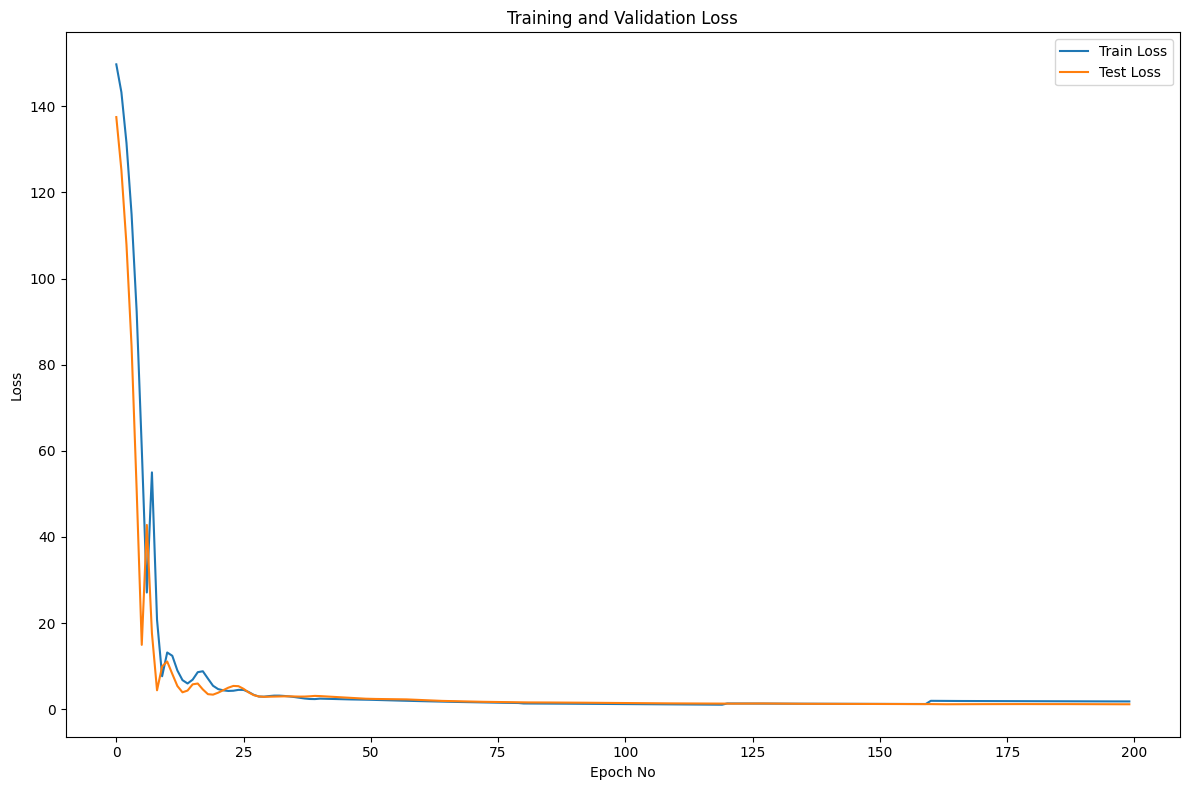

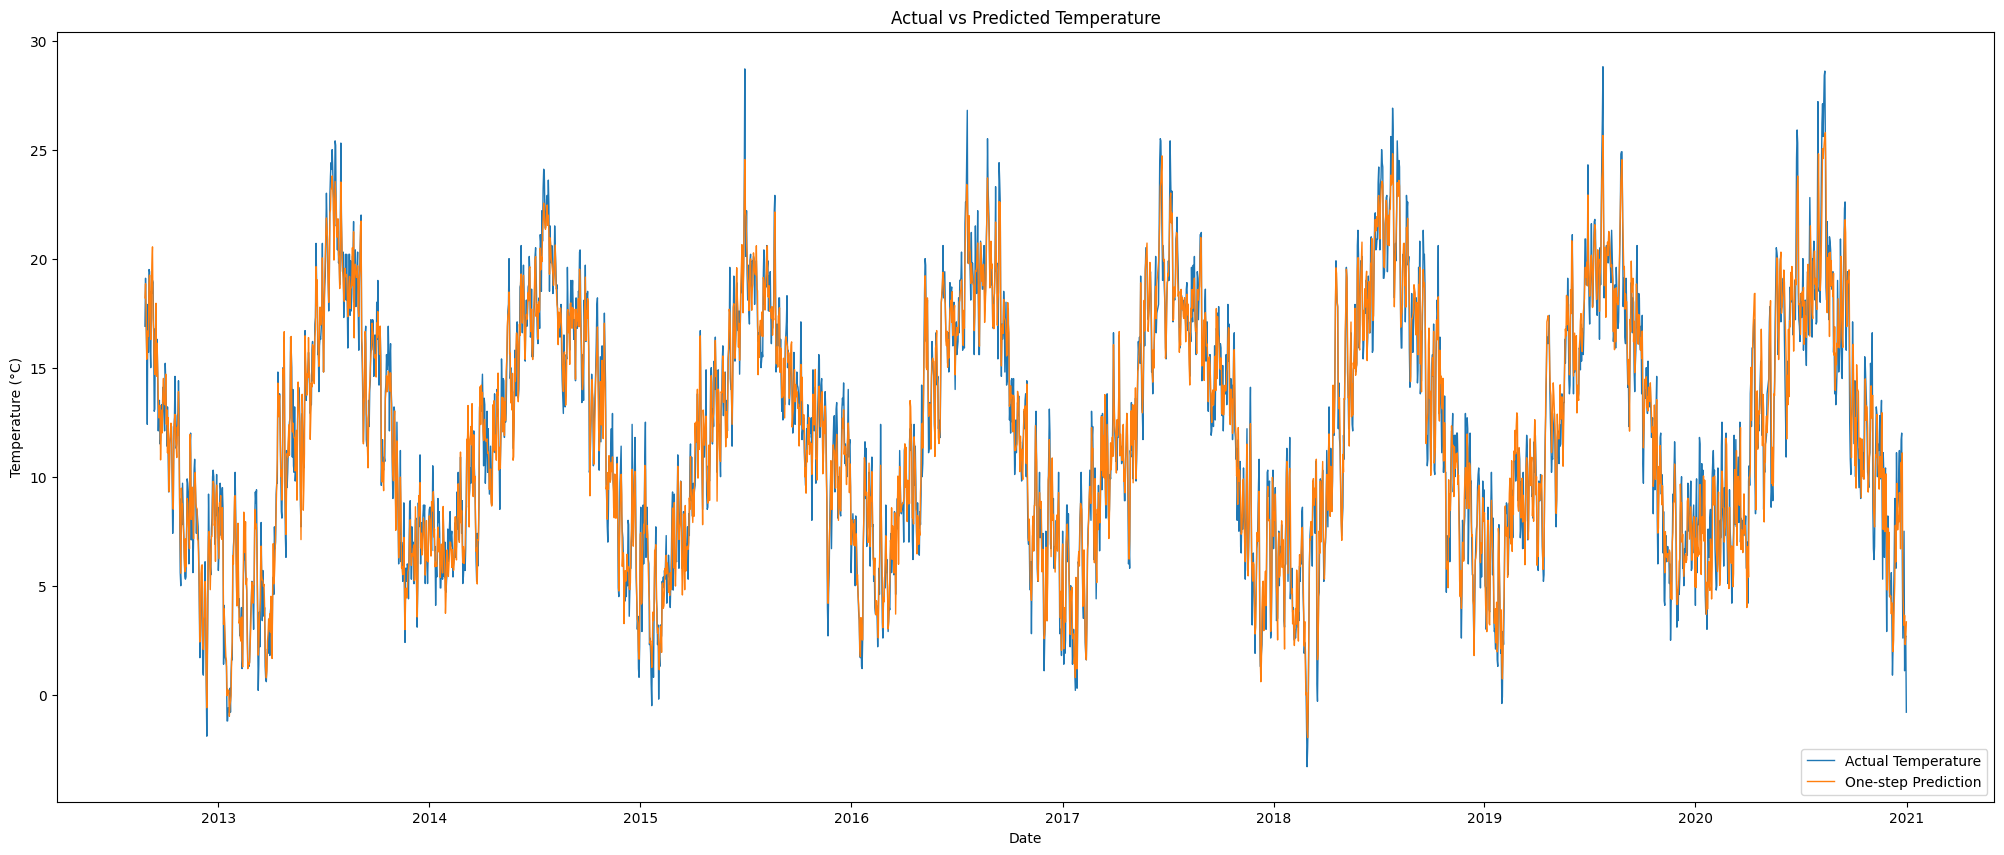

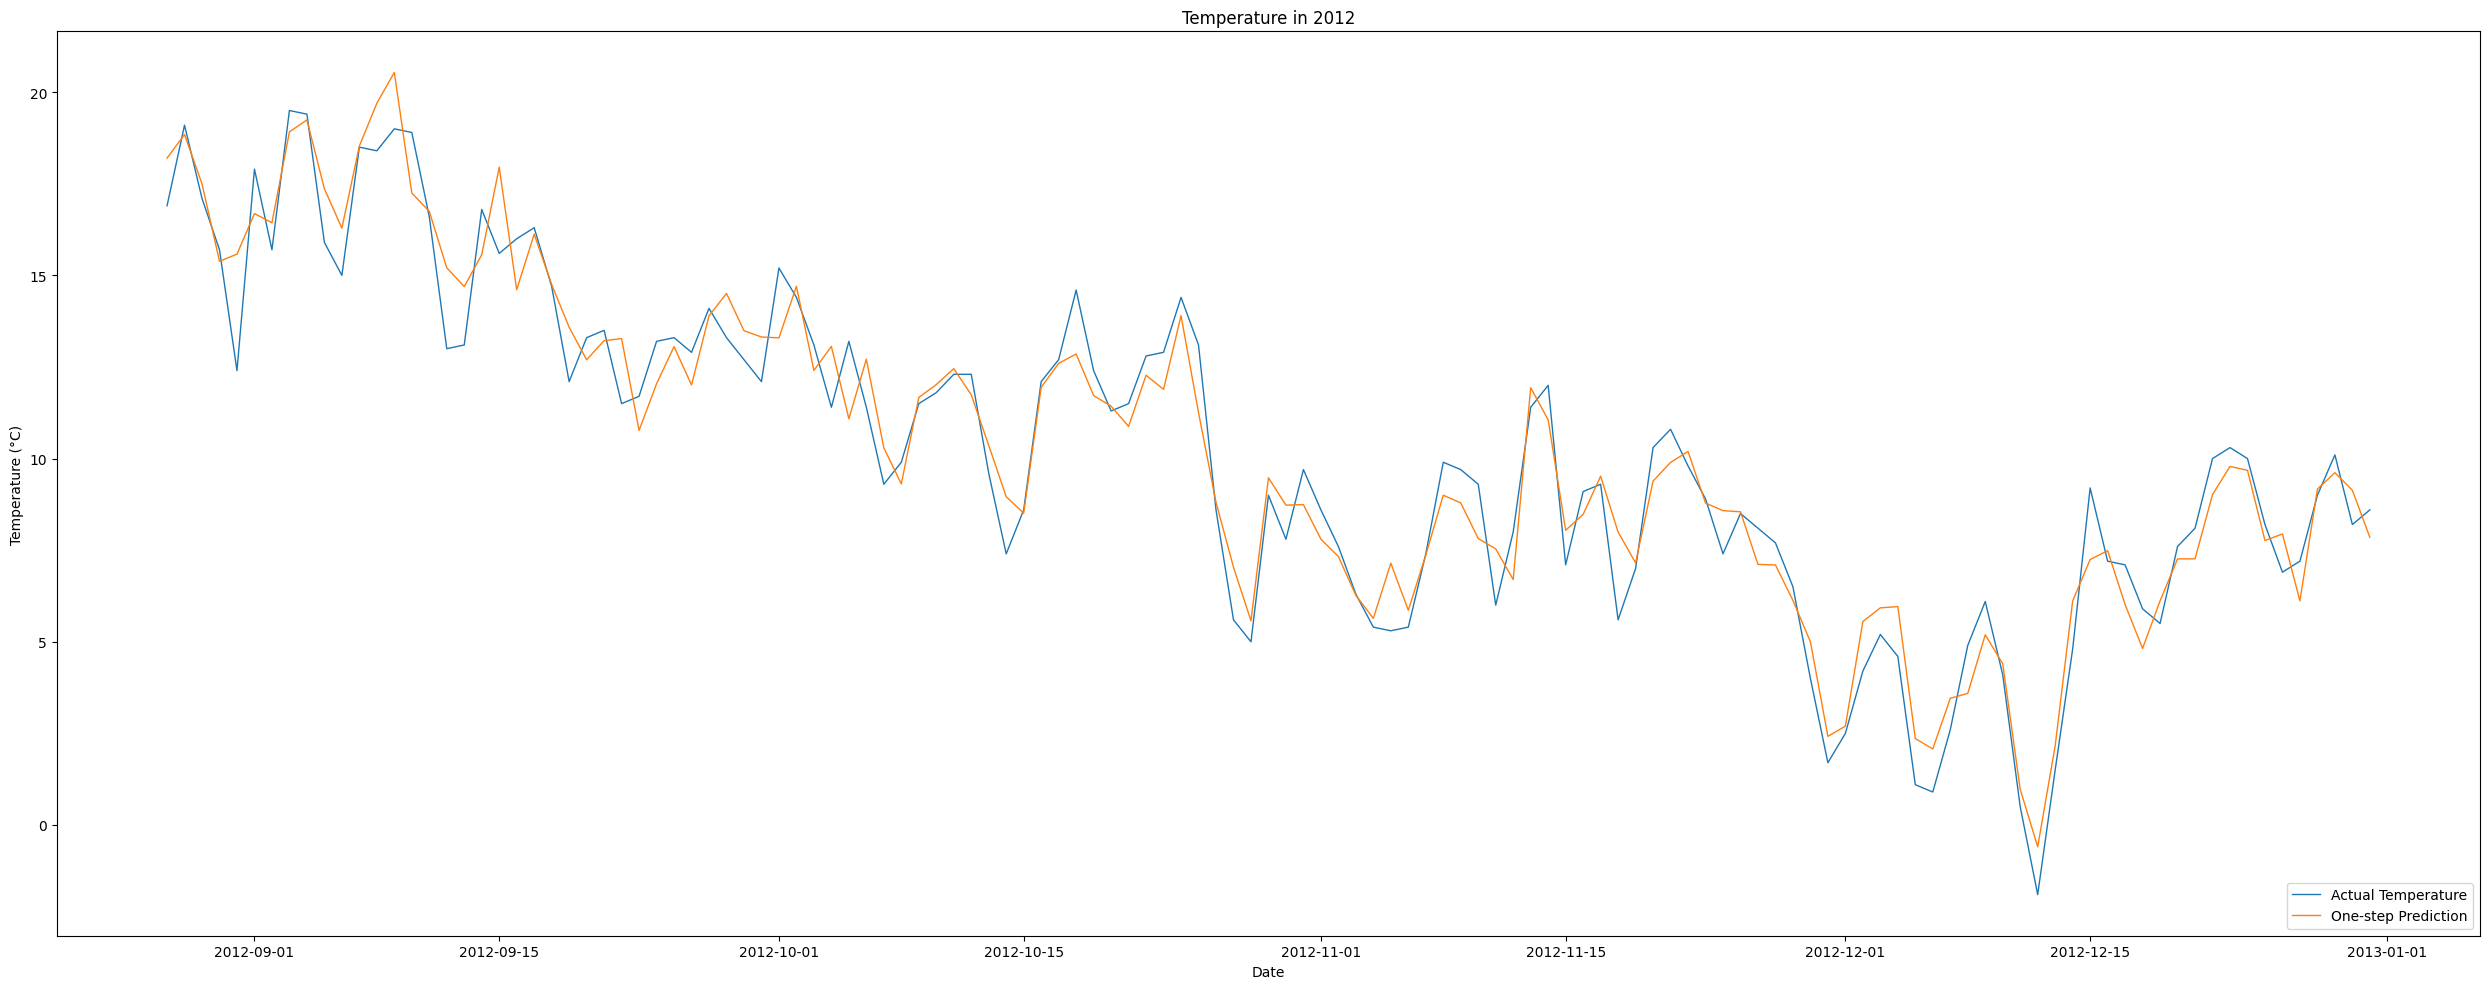

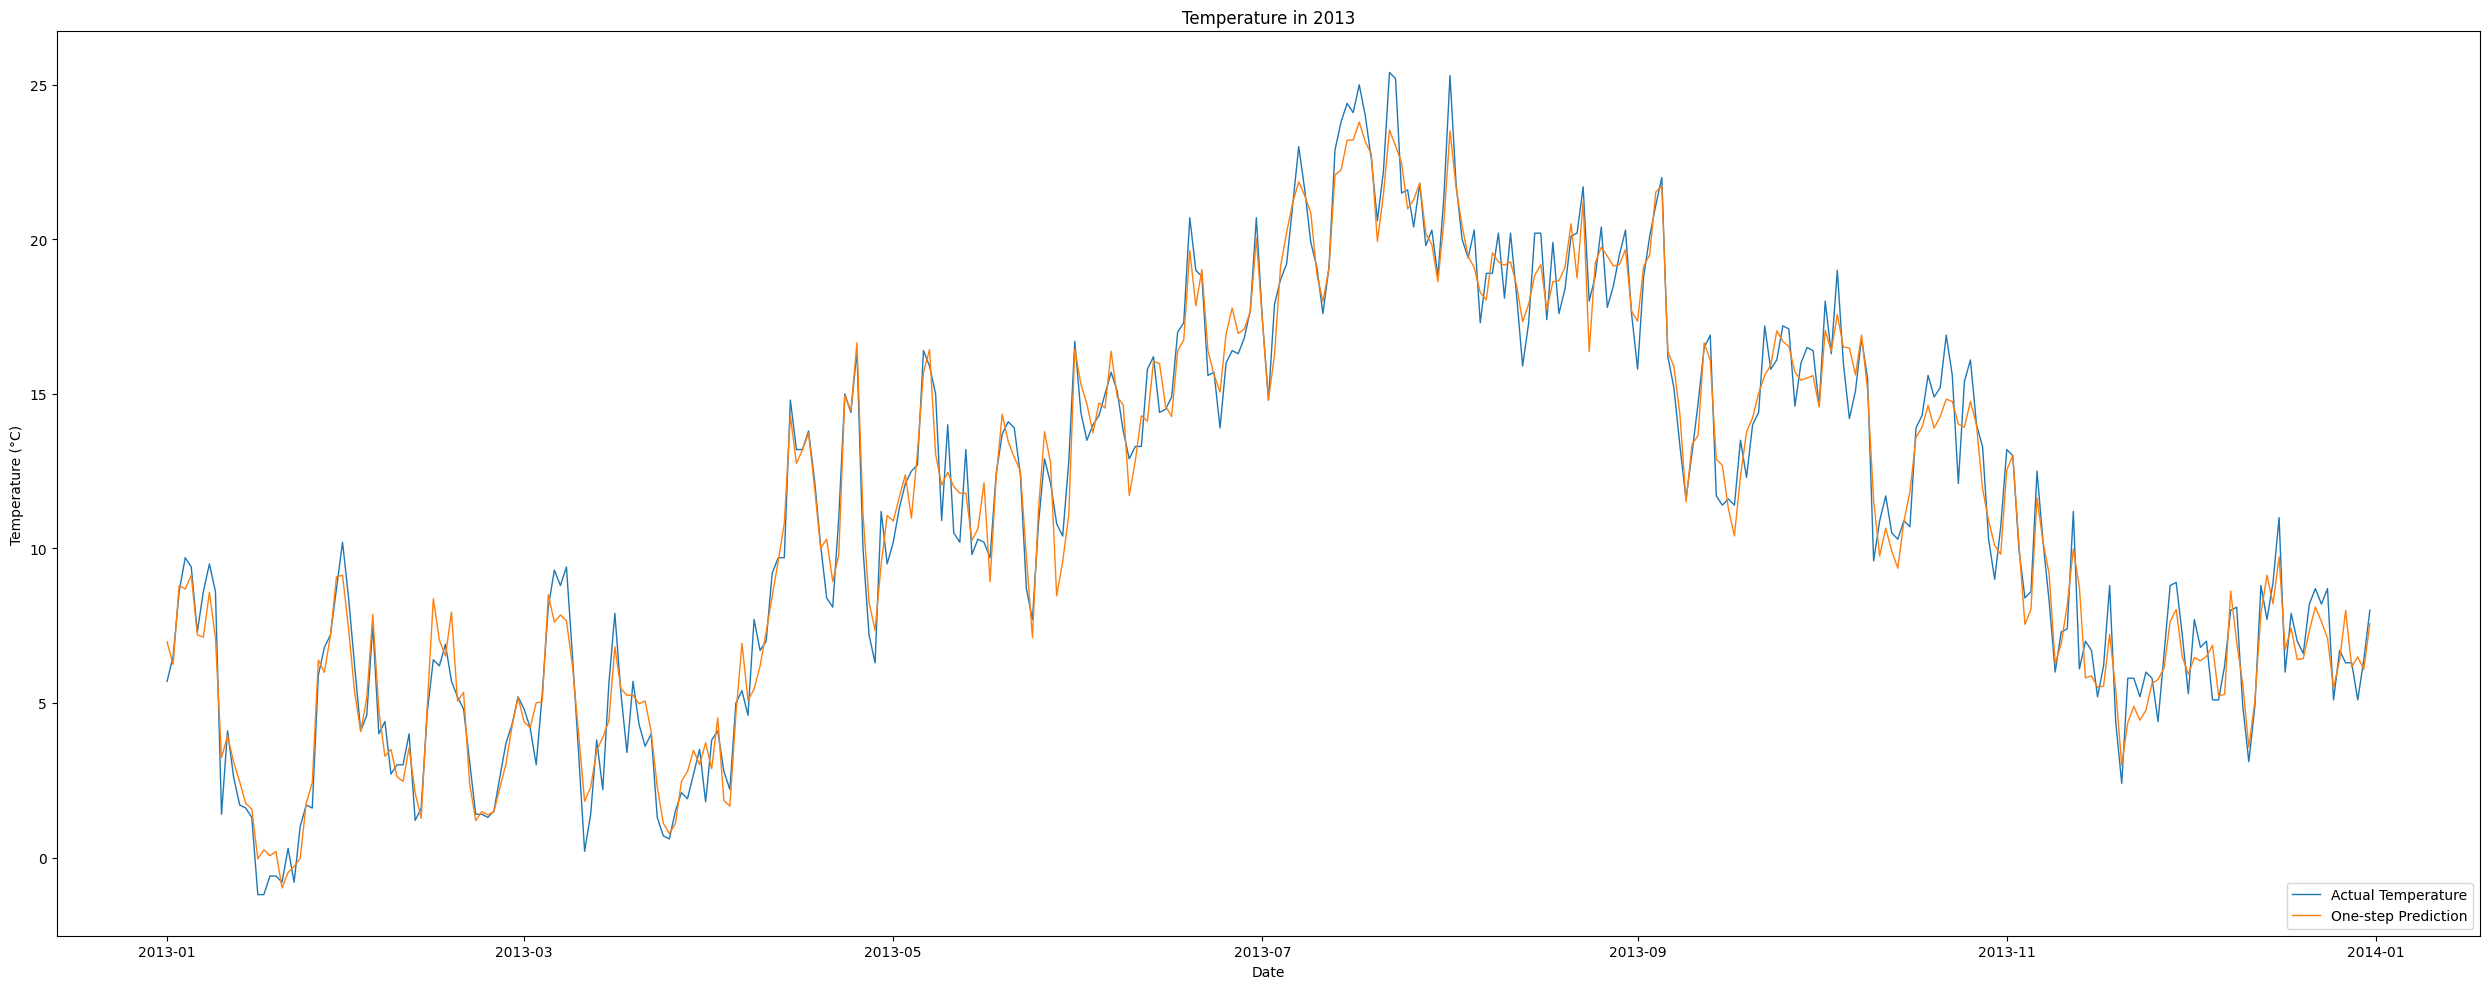

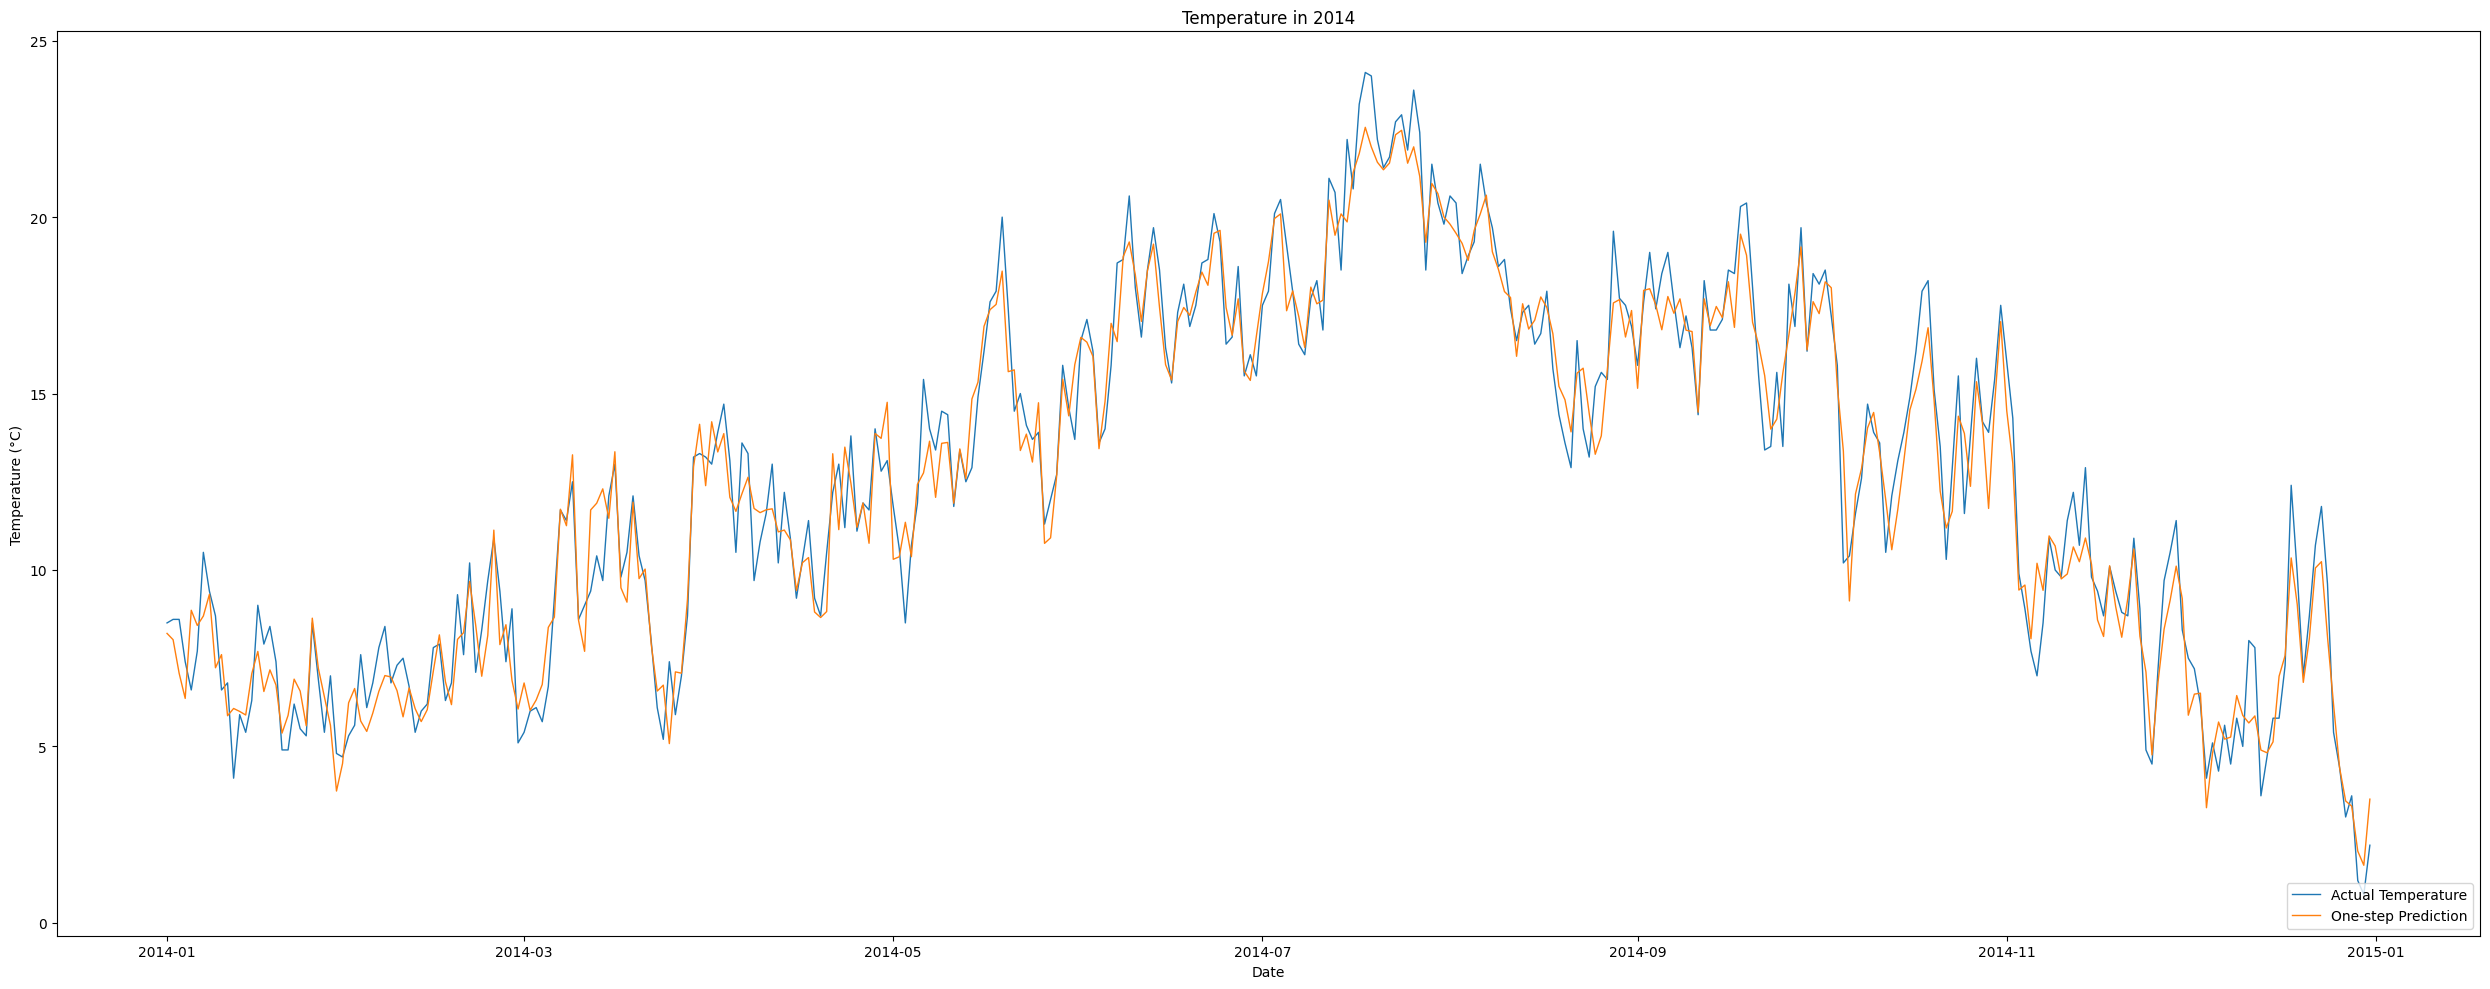

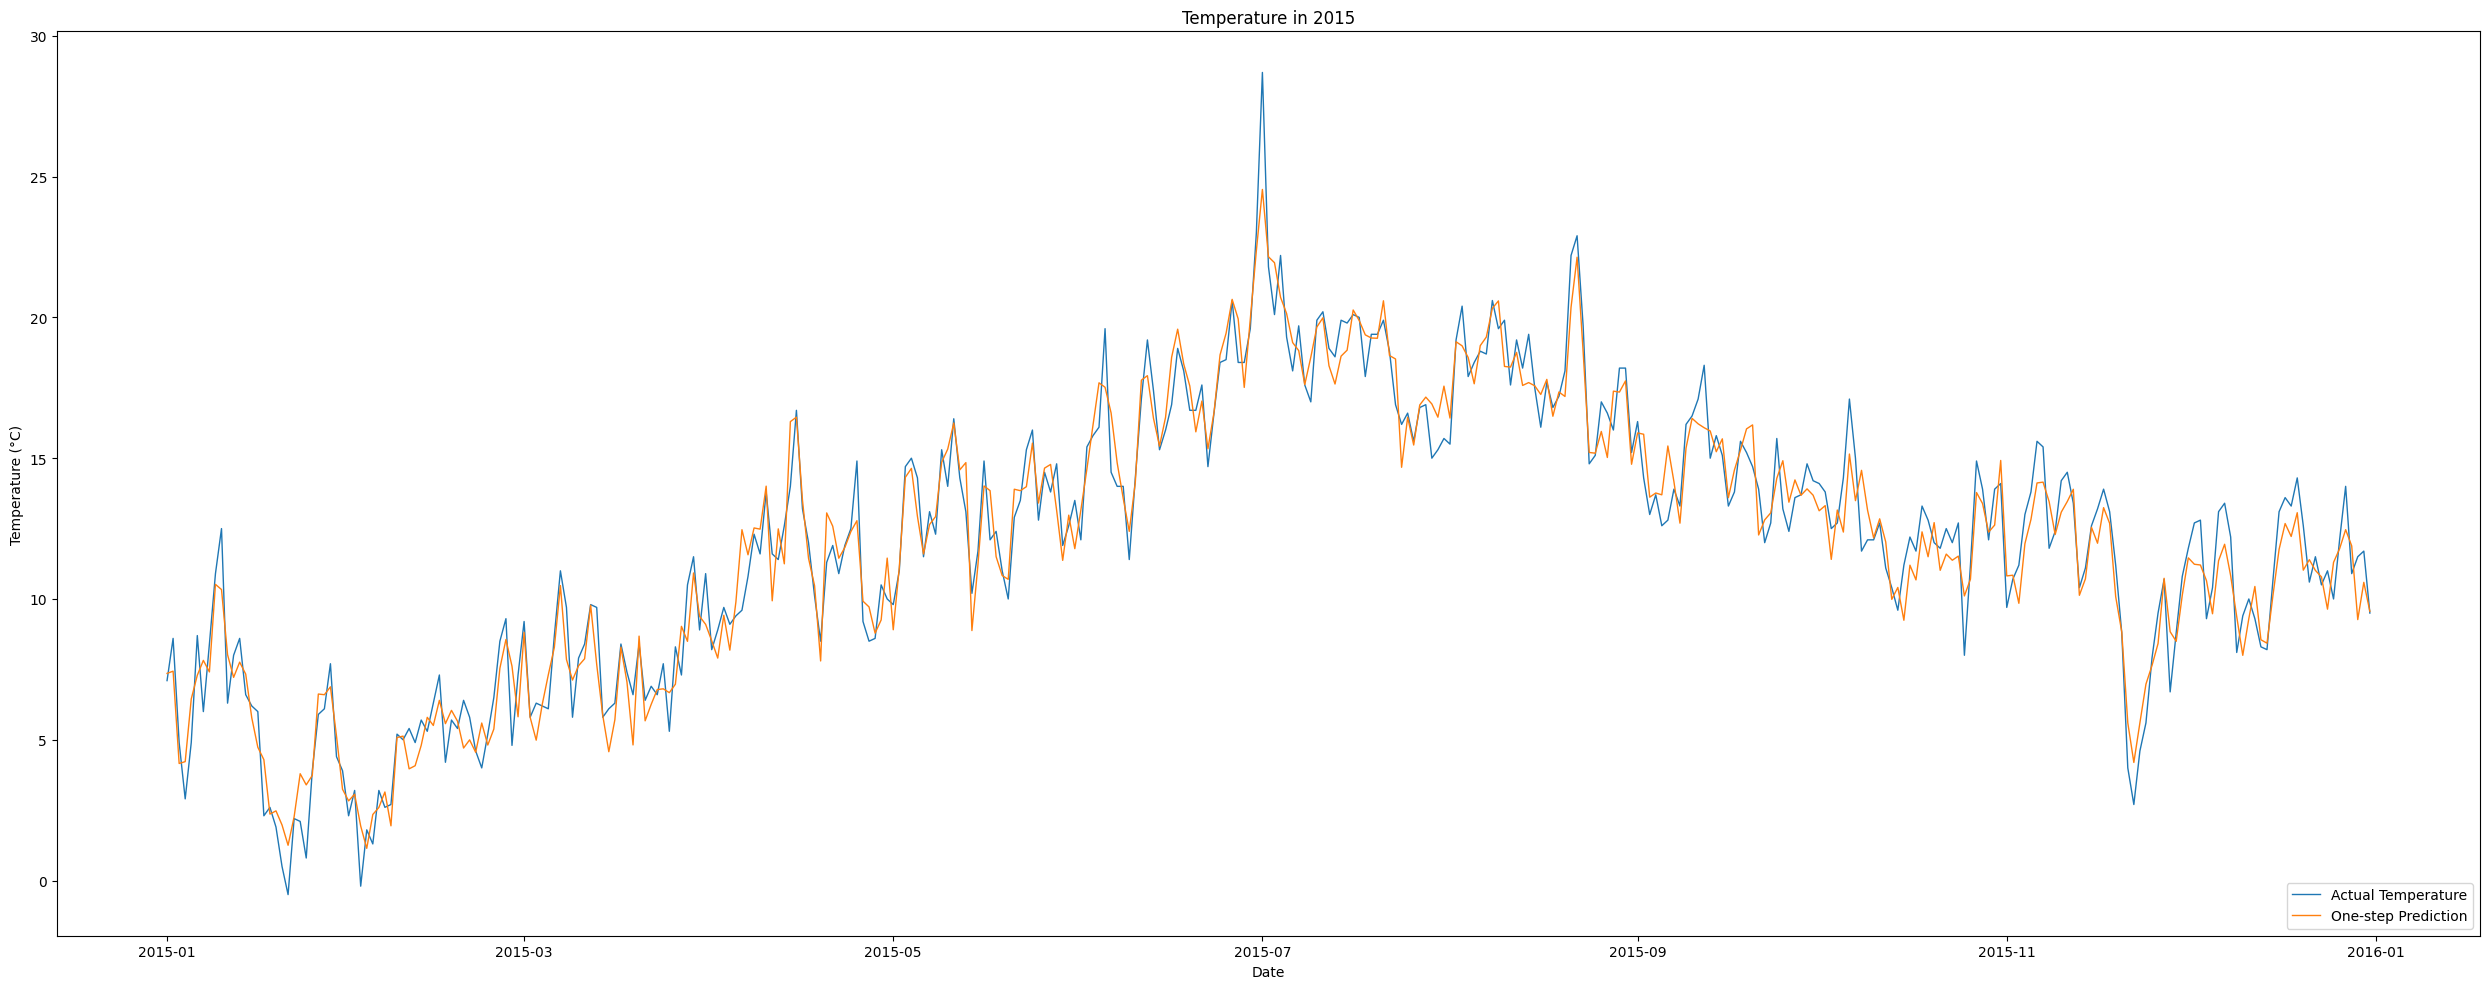

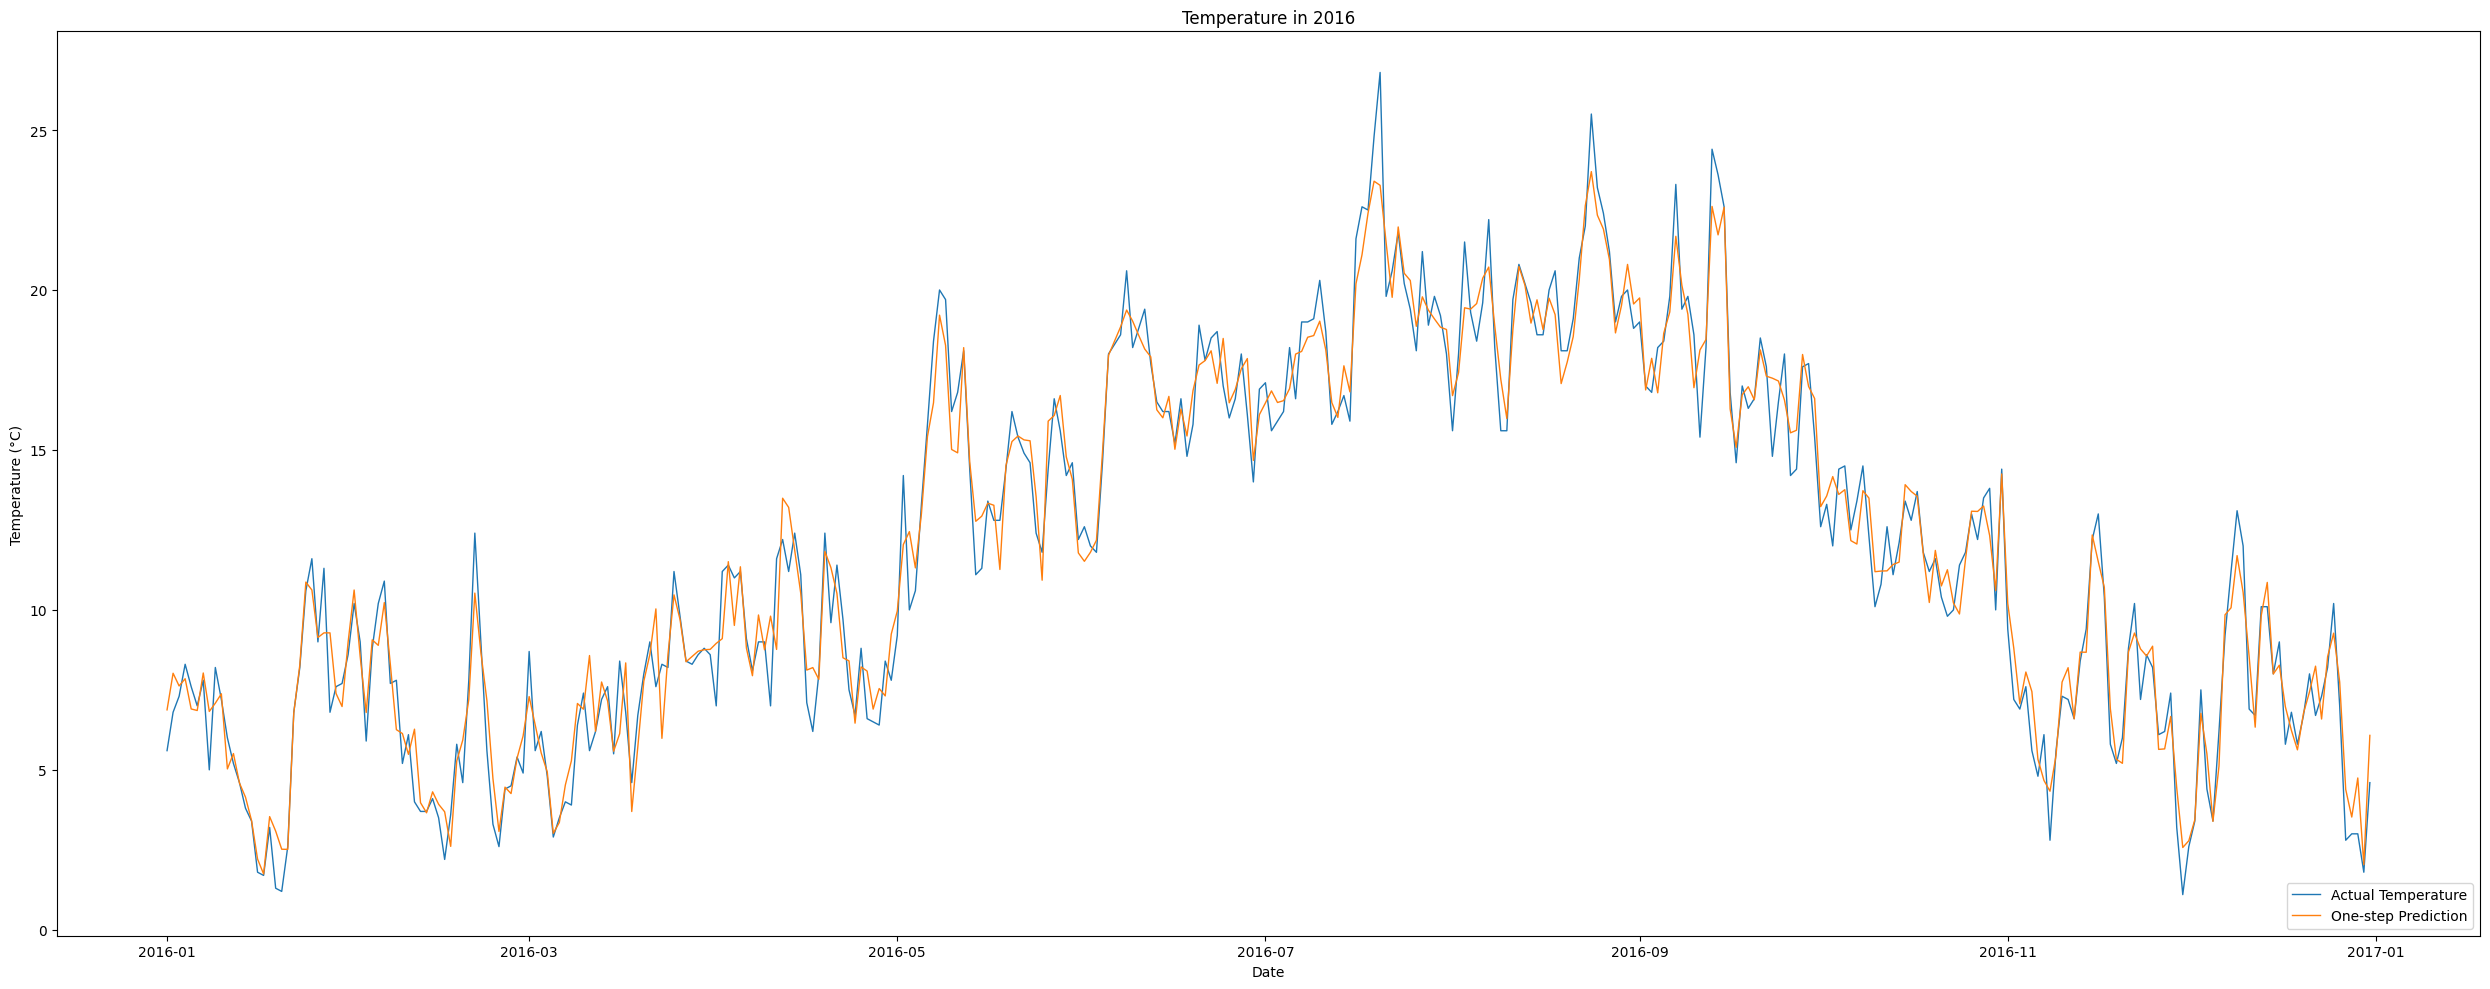

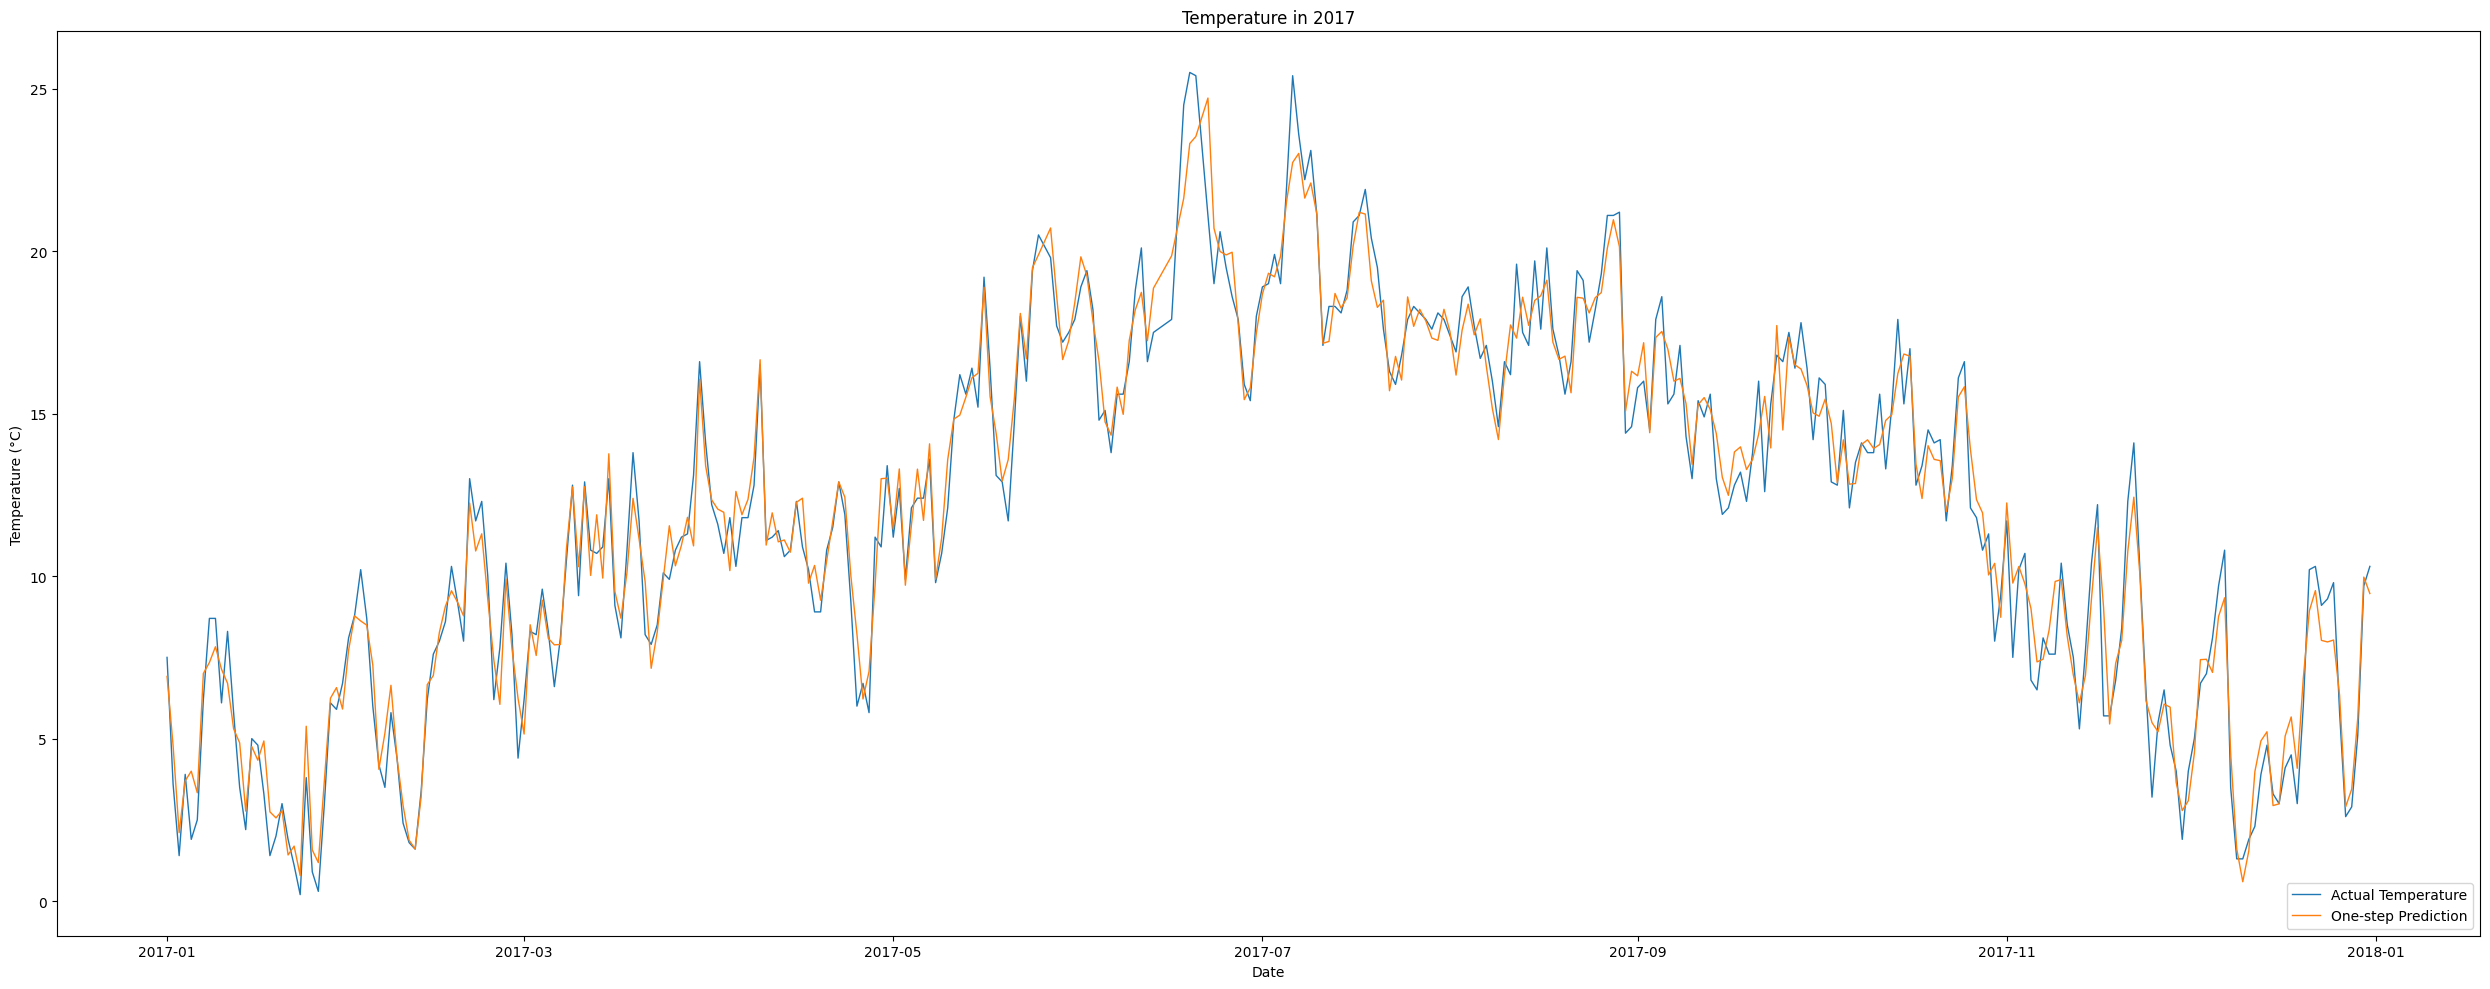

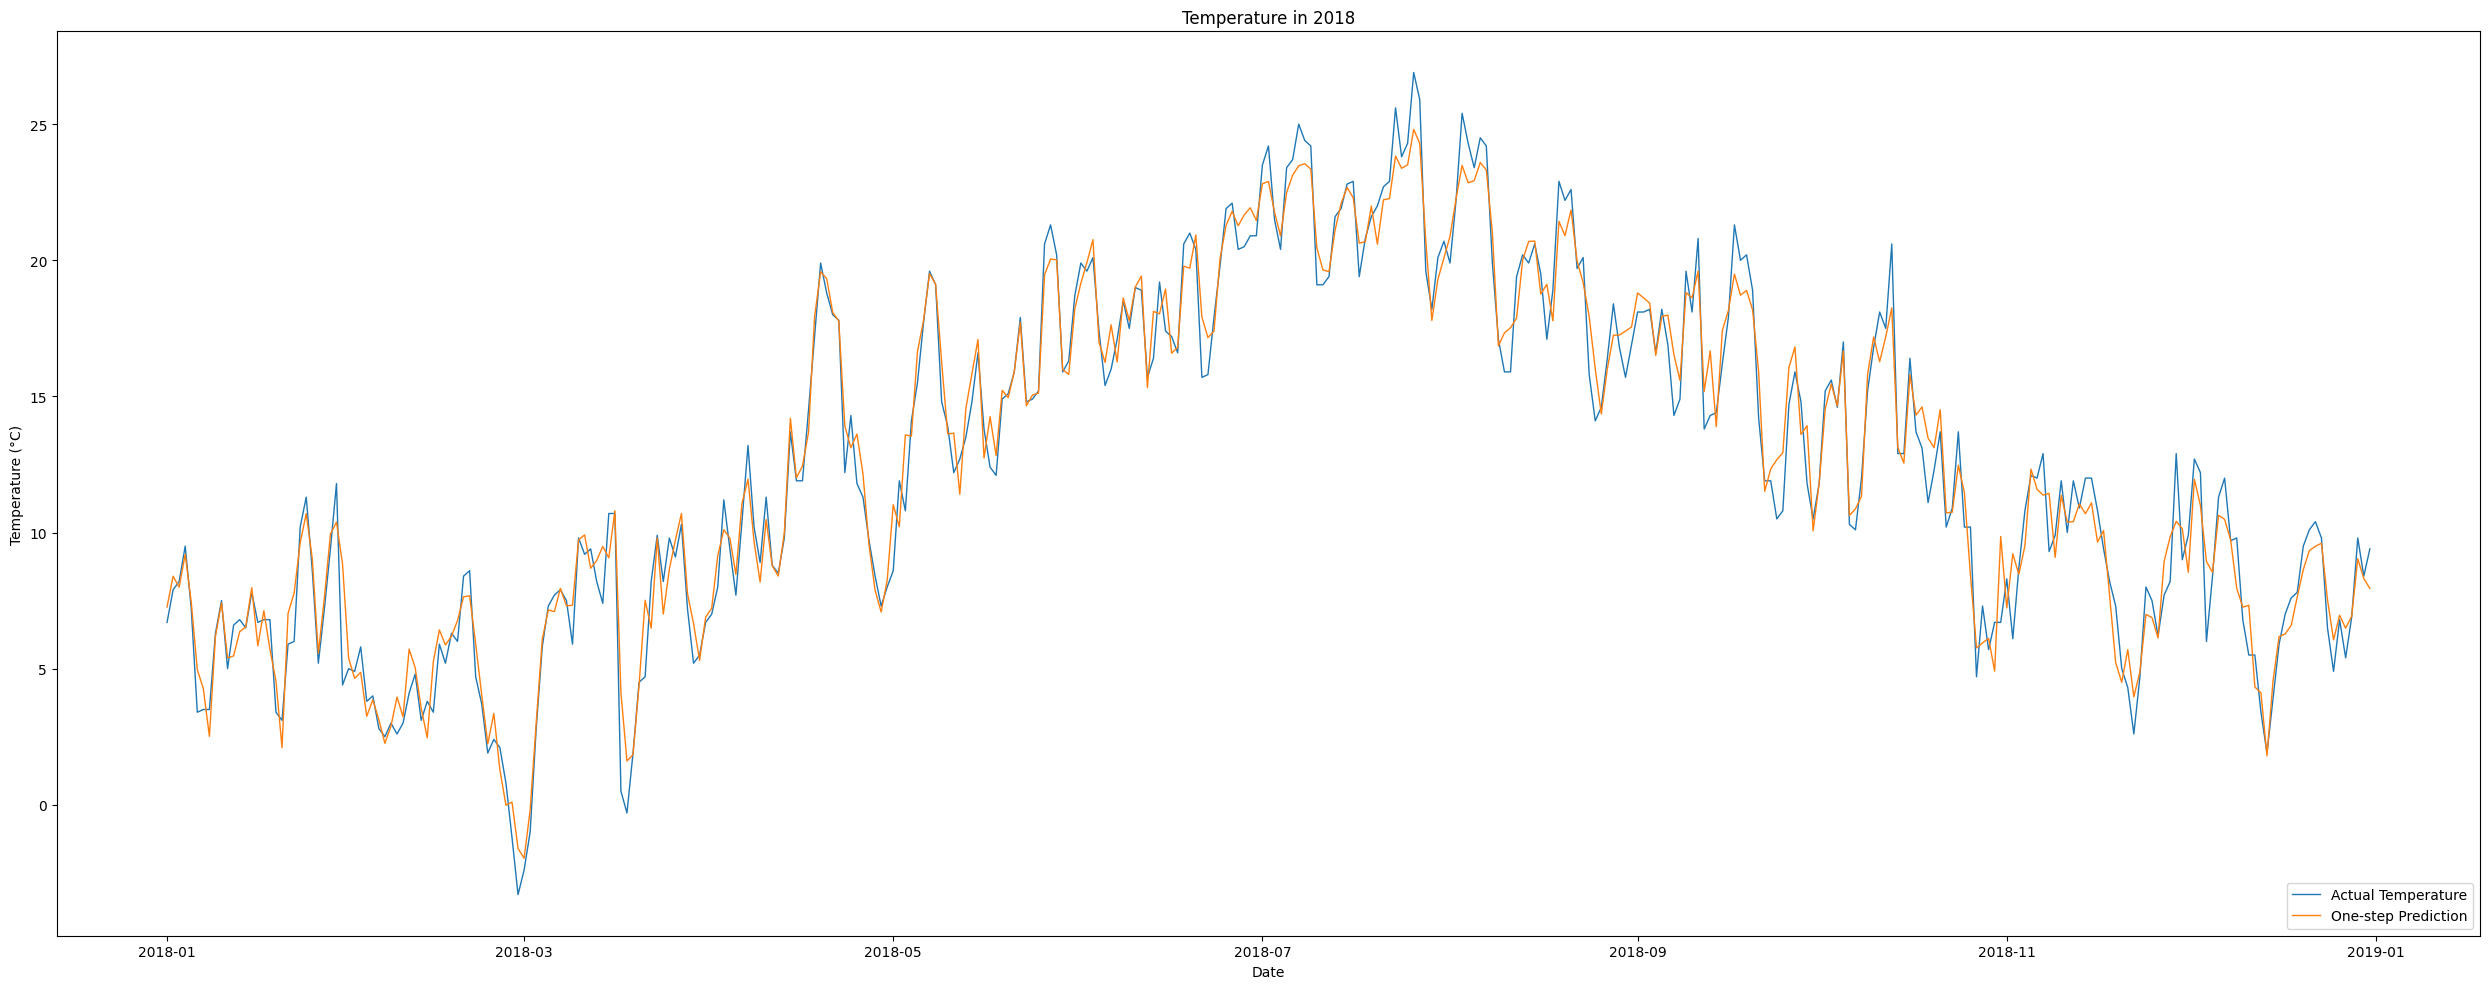

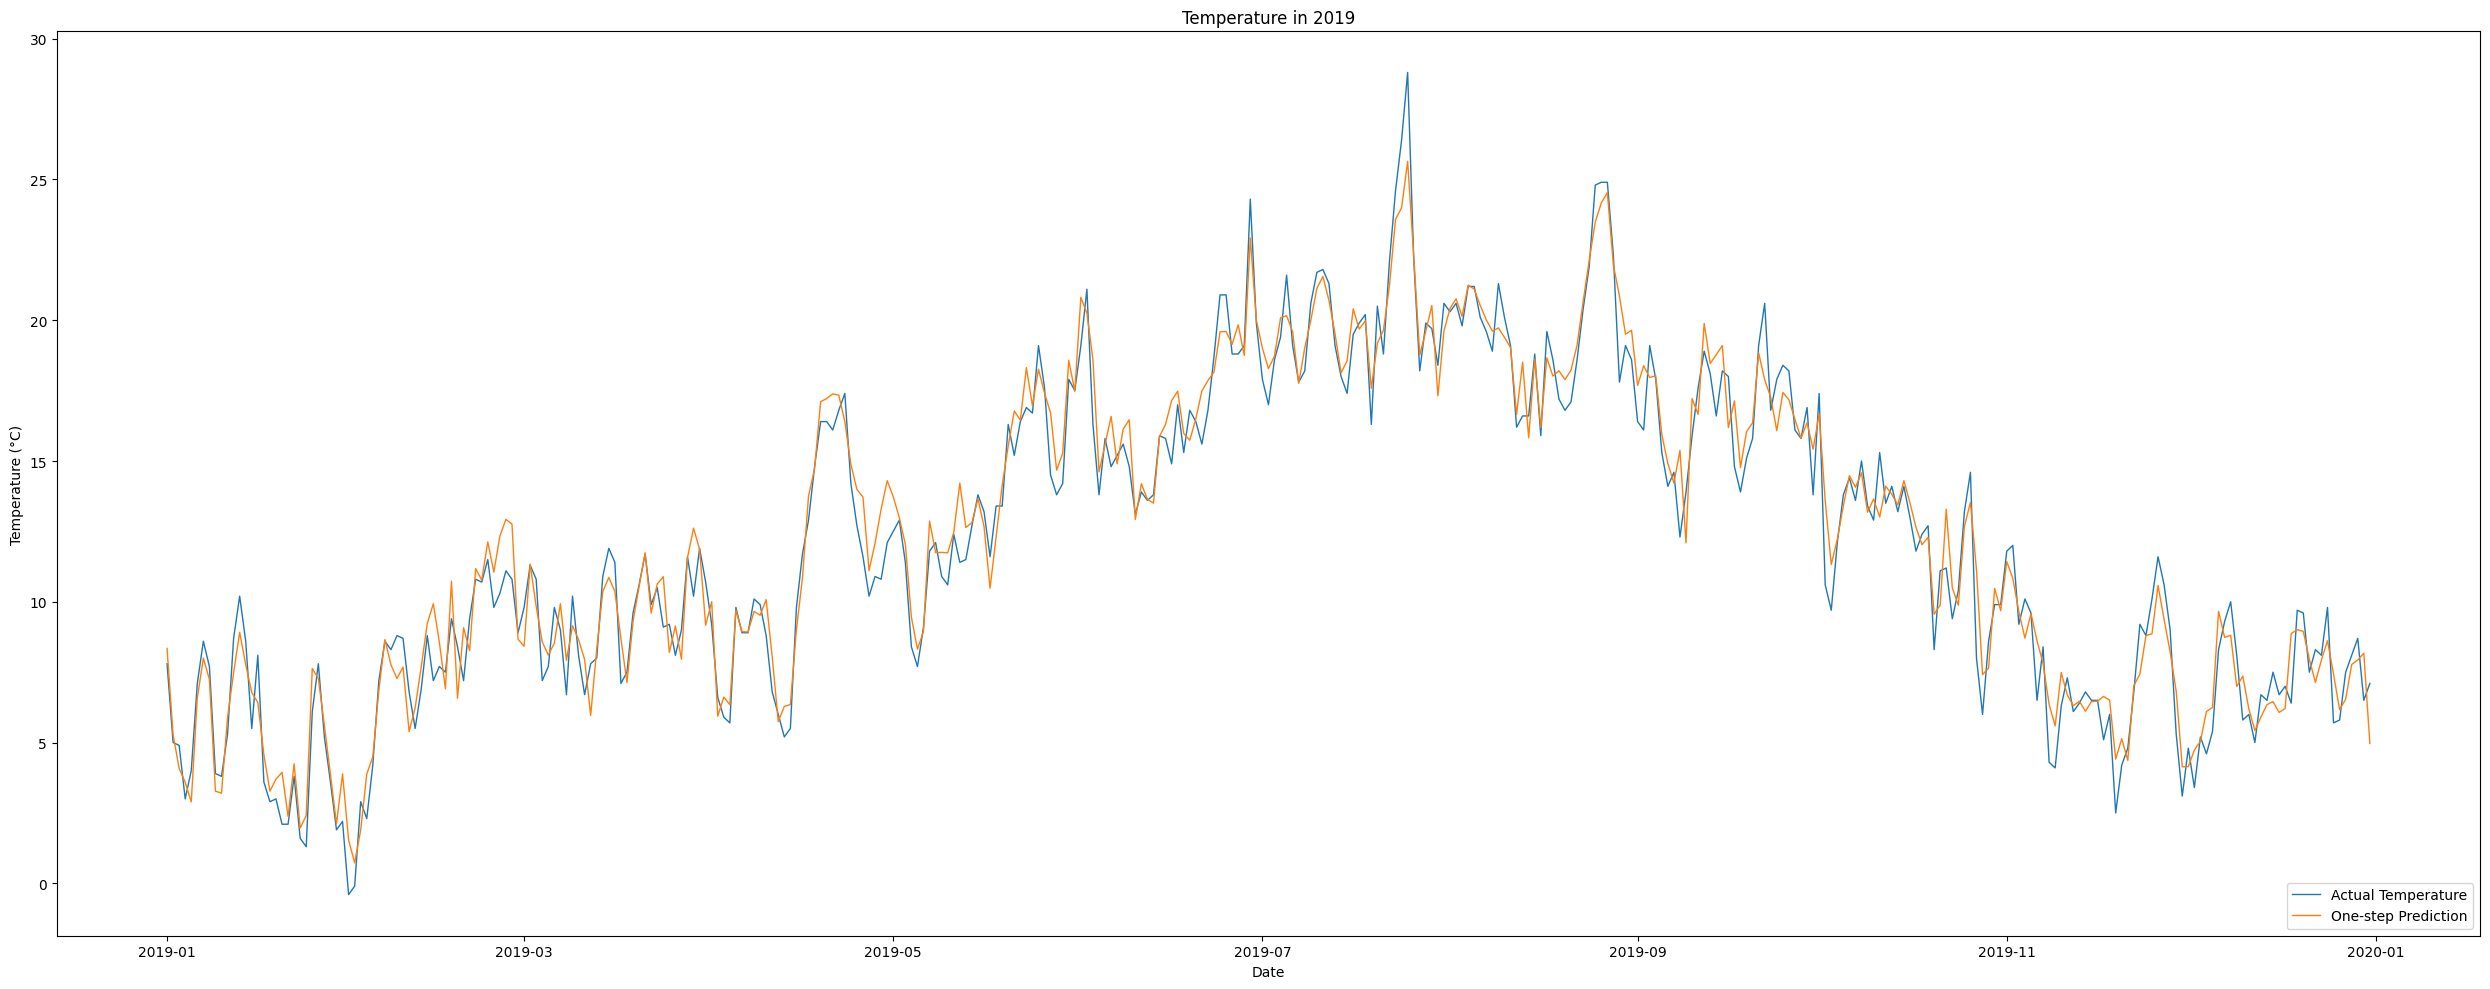

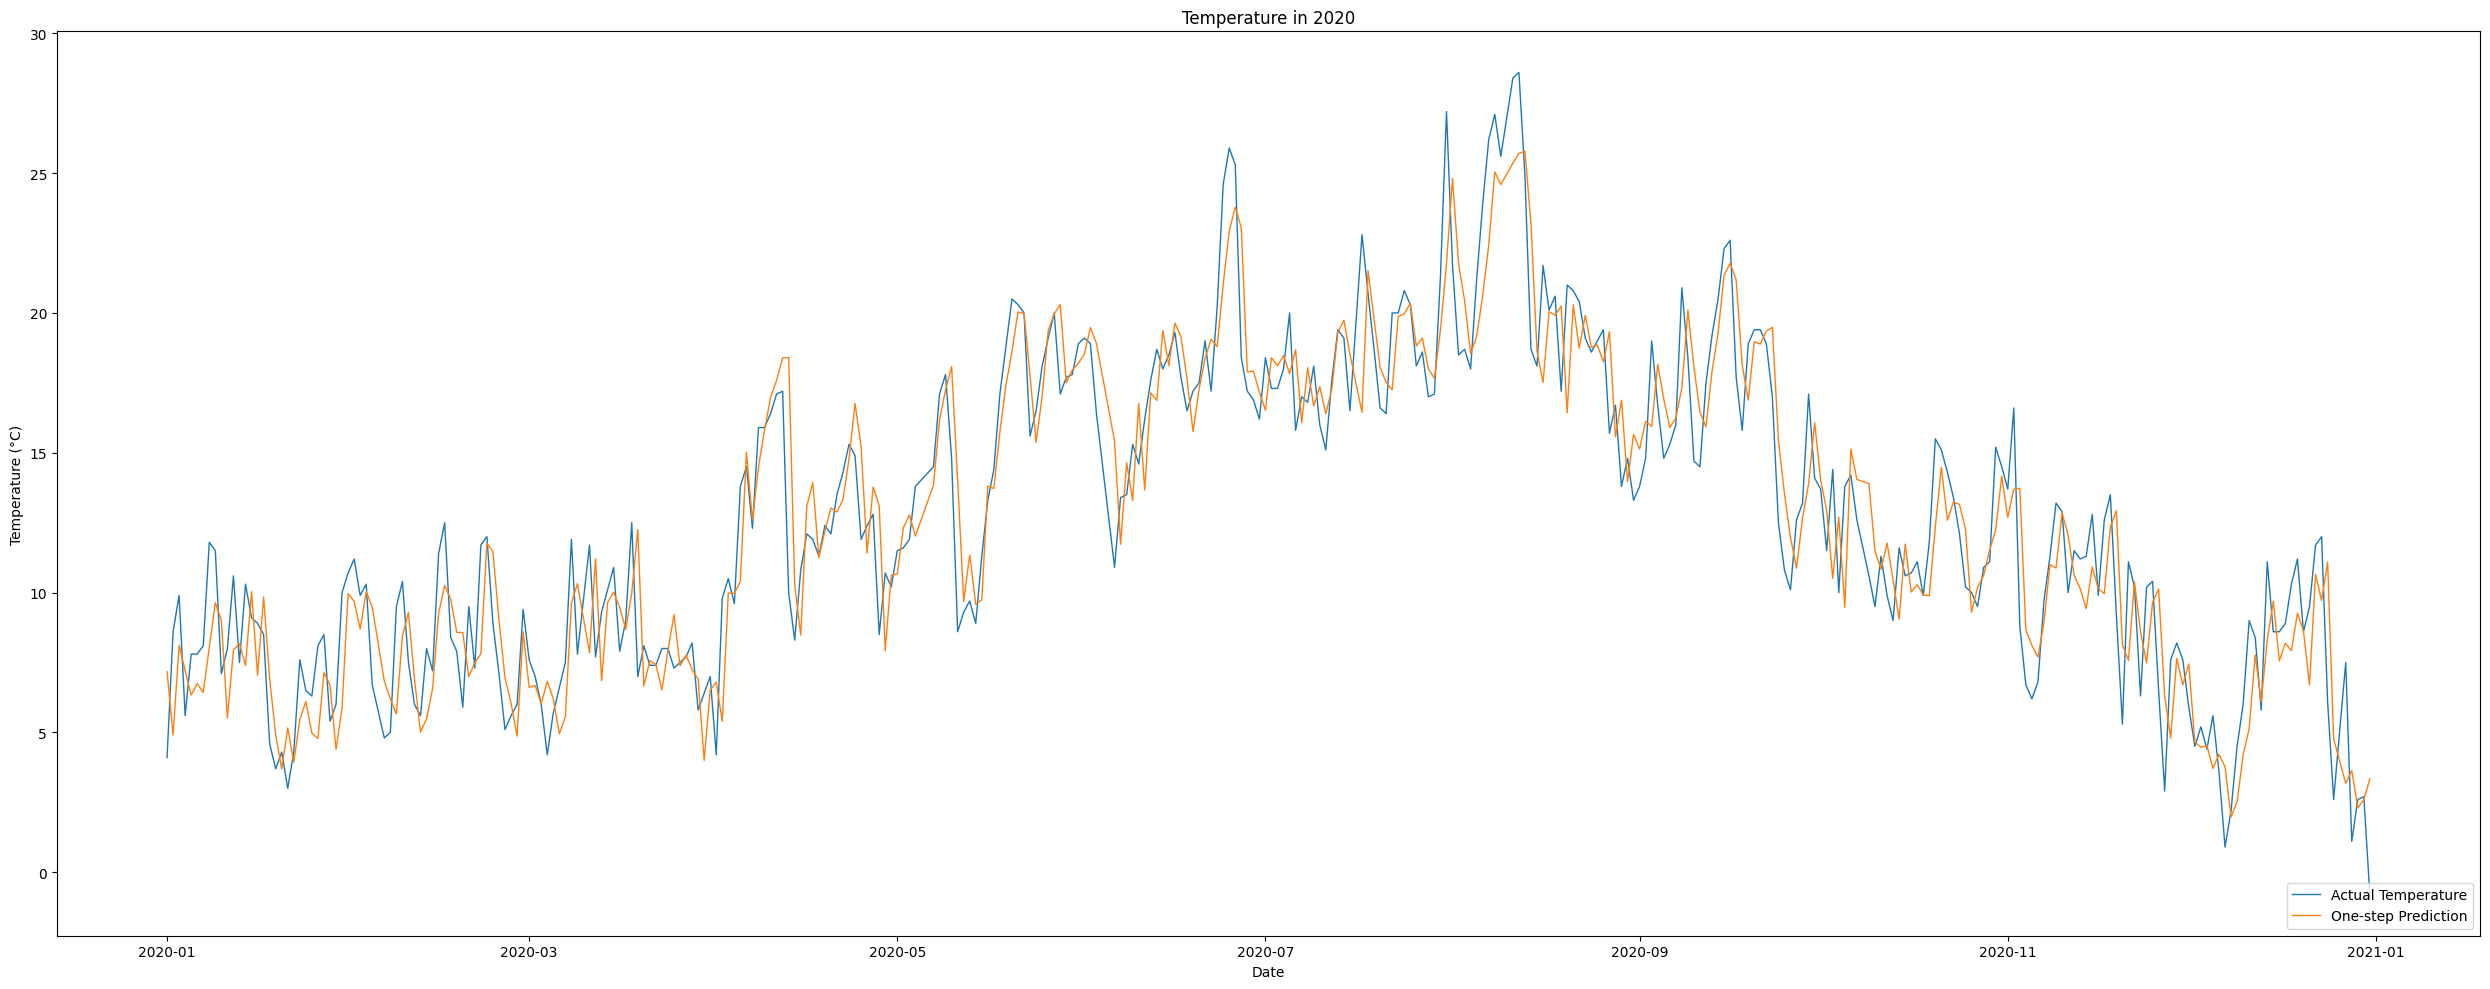

Mean square error is: 1.476


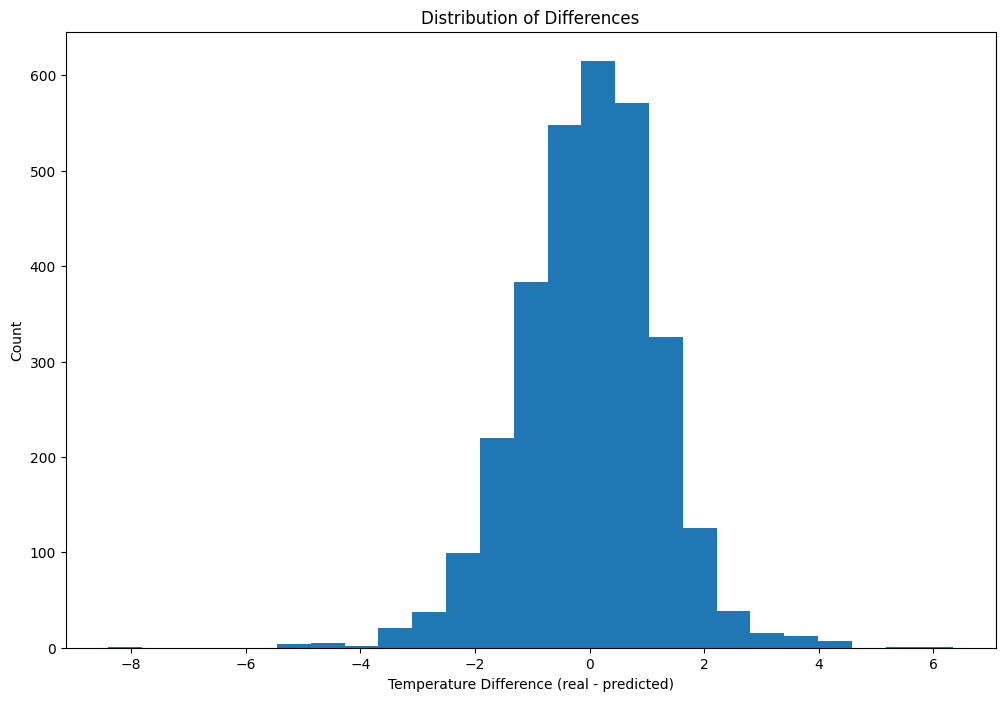

Metrics calculated - MAE: 1.028, MSE: 1.674, RMSE: 1.294
Error statistics - Mean: -0.470, Std: 1.205, Min: -3.181, Max: 1.652

Model Performance Metrics:
MAE: 1.0276
MSE: 1.6738
RMSE: 1.2938

[CONSOLE] Operation completed.
[CONSOLE] Total operation time taken is 111.33 seconds


In [12]:
# Get original data
original_data = preprocessor.get_original_data()

# Set up Display with configurable parameters for visualization options
displayer = Display(
    show_loss_plot=True,
    show_main_plot=True,
    show_yearly_plot=True,
    show_error_hist=True)

displayer.set_data(original_data, test_predictions, start_idx=-len(test_predictions))
displayer.set_test_data(test_target, test_predictions)

# Plot training history with proper labels
displayer.plot_training_history(all_train_losses, all_test_losses)

# Plot one-step predictions
displayer.plot_one_step_predictions()

# Plot by year with correct label
displayer.plot_by_year()

# Analyze LSTM error and show distribution
lstm_error_df, mse = displayer.analyze_lstm_error()

# Set up Analysis for metrics
analyzer = Analysis()
analyzer.set_data(y_test[:len(all_predictions)], all_predictions)
metrics = analyzer.calculate_metrics()
errors, error_stats = analyzer.analyze_error_distribution()

# Metrics
print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

main_end_time = time.time()
print('\n[CONSOLE] Operation completed.')
print(f'[CONSOLE] Total operation time taken is {main_end_time - main_start_time:.2f} seconds')